# 1. Hard SVM with 2 features and 10 samples

In [1]:

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
data = datasets.load_iris()
from sklearn.preprocessing import StandardScaler

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt
import random
import jax

from copy import deepcopy

CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

seed = 23

random.seed(seed)
# Set seed for NumPy
np.random.seed(seed)
# Set seed for PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
# Set seed for JAX
key = jax.random.PRNGKey(seed)

In [2]:
def select_n_points(data_X, data_y, n):
    # Check if n is even
    if n % 2 != 0:
        raise ValueError("n must be an even number to select equal points from both classes.")

    # Separate the data into two classes: +1 and -1
    class_pos = data_X[data_y == 1]  # Class +1
    class_neg = data_X[data_y == -1]  # Class -1

    # Check if enough points exist in both classes
    if len(class_pos) < n // 2 or len(class_neg) < n // 2:
        raise ValueError("Not enough data points in one or both classes to select n points.")

    # Randomly select n//2 points from each class
    selected_pos = class_pos[np.random.choice(len(class_pos), n // 2, replace=False)]
    selected_neg = class_neg[np.random.choice(len(class_neg), n // 2, replace=False)]

    # Combine the selected points and their labels
    selected_X = np.vstack((selected_pos, selected_neg))
    selected_y = np.hstack((np.ones(n // 2), -np.ones(n // 2)))

    # Shuffle the selected points and labels
    selected_X, selected_y = shuffle(selected_X, selected_y, random_state=42)

    return selected_X, selected_y

In [3]:
X = data.data 
y = data.target
feature_names = data.feature_names

X = pd.DataFrame(X, columns=feature_names) 

# Filter out the rows where y is 2
mask = (y != 2)
X_filtered = X[mask]  # Only keep rows where y is not 2
y_filtered = y[mask]  # Only keep corresponding labels

# Encode y to be +1 and -1
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)
y_encoded[y_encoded == 0] = -1  # Replace 0 with -1

# Now X_filtered contains the features and y_encoded contains the -1 and +1 labels
data_X = X_filtered[['sepal length (cm)', 'sepal width (cm)']].to_numpy()
data_y = y_encoded

[Text(0.5, 0, 'sepal length (cm)'), Text(0, 0.5, 'sepal width (cm)')]

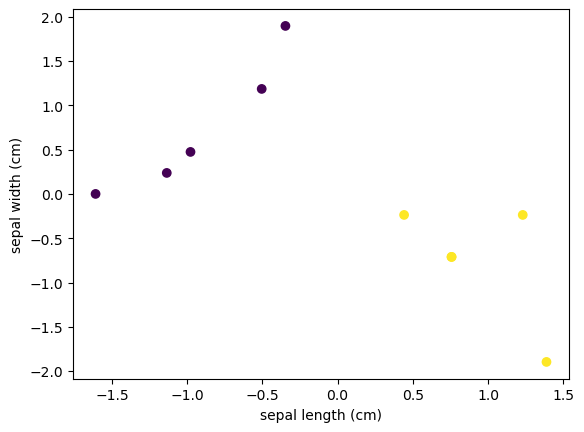

In [4]:
n = 10
selected_X, selected_y = select_n_points(data_X, data_y, n)
scaler = StandardScaler()
selected_X = scaler.fit_transform(selected_X)
_, ax = plt.subplots()
scatter = ax.scatter(selected_X[:, 0], selected_X[:, 1], c=selected_y)
ax.set(xlabel='sepal length (cm)', ylabel='sepal width (cm)')

In [5]:
# Define the plotting function
def plot_svm_decision_boundary(X, y, w, b, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Plot decision boundary
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Use only the selected features for the decision boundary
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.dot(grid, w[[feature_x_idx, feature_y_idx]]) + b
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])
    
    plt.xlabel(f'sepal length (cm)')
    plt.ylabel(f'sepal width (cm)')
    plt.legend()
    plt.title('Hard Margin SVM Decision Boundary')
    plt.show()
    
# Define the modified plotting function to plot two decision boundaries
def plot_svm_decision_boundary_confrontation(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['Ground Truth', 'ODE Solution', 'Iris versicolor', 'Iris setosa']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'sepal length (cm)')
    plt.ylabel(f'sepal width (cm)')
    plt.title('SVM Decision Boundaries')
    plt.show()

In [6]:
def adjust_label_positions(positions, min_distance=0.02):
    """Adjust vertical positions of labels to avoid overlap."""
    sorted_positions = sorted(enumerate(positions), key=lambda x: x[1])
    adjusted_positions = positions.copy()
    
    for i in range(1, len(sorted_positions)):
        curr_idx, curr_pos = sorted_positions[i]
        prev_idx, prev_pos = sorted_positions[i-1]
        
        if curr_pos - prev_pos < min_distance:
            adjusted_positions[curr_idx] = prev_pos + min_distance
    
    return adjusted_positions

def plot_ode_system(t_values, y_values):
    plt.figure(figsize=(8, 6))
    # Enable LaTeX rendering
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Plot each line and prepare label information
    labels = [f'w_{i}' for i in range(1,3)] + ['b'] + [f'u_{i}' for i in range(1, 11)]
    colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))
    label_positions = []

    for i, (label, color) in enumerate(zip(labels, colors)):
        line = plt.plot(t_values, y_values[i, :], label=label, color=color)[0]
        label_positions.append(y_values[i, -1])

    # Adjust label positions
    y_min, y_max = np.min(y_values), np.max(y_values)
    y_range = y_max - y_min
    min_distance = 0.02 * y_range  # 2% of y-range as minimum distance
    adjusted_positions = adjust_label_positions(label_positions, min_distance)

    # Add adjusted labels with increased font size and space
    fontsize = 14  # Adjust the font size here
    x_offset = 1  # Space to move the label away from the line
    
    for i, (label, color, position) in enumerate(zip(labels[:3], colors[:3], adjusted_positions[:3])):
        math_label = f"${label}$"  # Add space with LaTeX's \quad
        x_end = t_values[-1]
        plt.text(x_end + x_offset, position, f' {math_label}', verticalalignment='center', 
                 horizontalalignment='left', color=color, fontsize=fontsize)

    plt.xlabel('Time', fontsize=fontsize)
    plt.ylabel('y(t)', fontsize=fontsize)
    plt.title('ODE System Solution', fontsize=fontsize)
    plt.grid(False)

    # Adjust the plot limits to make room for labels
    plt.xlim(t_values[0], t_values[-1] * 1.1)  # Extend x-axis by 10%
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)  # Extend y-axis by 10% on both ends

    plt.tight_layout()
    plt.show()

Time: 0.012940645217895508
Optimal objective value: 0.8050052238402077
SCS solver iterations: 125
SCS solve time: 0.001981184
SCS setup time: 0.00157365
Optimal w:  [ 1.0562039  -0.70316695]
Optimal b:  [0.36667032]
Dual variables (Lagrange multipliers): [0.26073366 0.         0.27347295 0.80499977 0.         0.
 0.         0.         0.         0.27079356]
Constraints: [-0.00000222 -2.1666768  -0.00000128 -0.00000586 -0.3333306  -0.66667396
 -0.33333817 -0.8333433  -0.66667396  0.00000156]


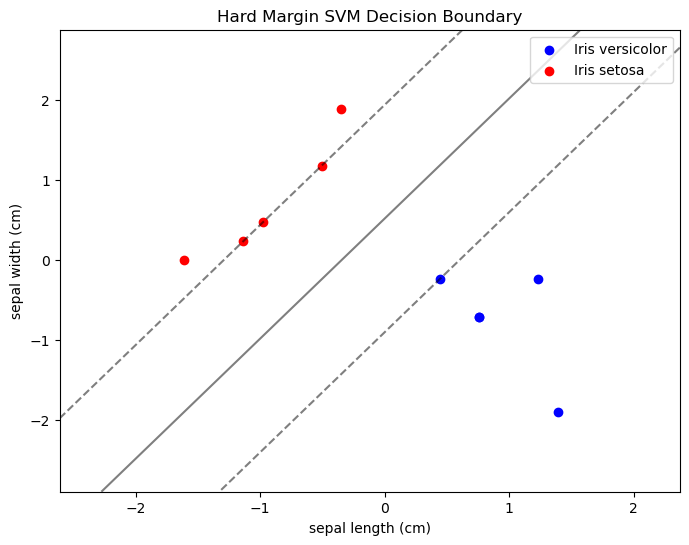

In [7]:
import cvxpy as cp
import numpy as np
import time

w = cp.Variable(2)
b = cp.Variable(1)

objective = cp.Minimize((1/2)*cp.norm(w, 2)**2)

constraints = [
    cp.multiply(selected_y, cp.matmul(selected_X, w) + b) >= 1,
]

problem = cp.Problem(objective, constraints)

t0 = time.time()
problem.solve(solver='SCS')
solve_time = time.time() - t0

# Get solver stats
solver_stats = problem.solver_stats
print('Time:', solve_time)
print('Optimal objective value:', problem.value)
print('SCS solver iterations:', solver_stats.num_iters)
print('SCS solve time:', solver_stats.solve_time)
print('SCS setup time:', solver_stats.setup_time)

# Get the values of the variables
print('Optimal w: ', w.value)
print('Optimal b: ', b.value)

# Get the dual variables
dual_variables = constraints[0].dual_value
print('Dual variables (Lagrange multipliers):', dual_variables)

g = [-selected_y[i] * (w.value @ selected_X[i] + b.value) + 1 for i in range(selected_y.shape[0])]
g_SCS = jnp.array(g).flatten()
print('Constraints:', g_SCS)

# Plotting
plot_svm_decision_boundary(selected_X, selected_y, w.value, b.value, 0, 1)

In [8]:
nw = selected_X.shape[1]
nb = 1
nx = nw + nb
nu = selected_X.shape[0]
NY = nx+nu

def f(x):
    w = x[:-1]
    output = (1/2) * jnp.linalg.norm(w, 2)**2
    return output

def g(x):
    w = x[:nw]
    b = x[nw]
    
    g = [-selected_y[i] * (w @ selected_X[i] + b) + 1 for i in range(selected_y.shape[0])]
    output = jnp.array(g)
    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    return xu

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -dx
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0.001).all():
        obj = f(x)
        #print('g(x) values:', g(x))
    else:
        obj = np.inf
        #print('g(x) values:', g(x))
    return obj

def constraints_diff(g_ODE, g_SCS):
    return jnp.abs(g_ODE - g_SCS).max()

In [9]:
def solve_ODE(xu0, T):
    sol = solve_ivp(ODE, [0., T], xu0, method=NUMERICAL_METHOD)
    result = P(sol.y[:, -1])
    print("objective:",evalutation(result))
    print("Constraints:",g(result[:nx]))
    diff = constraints_diff(g(result[:nx]), g_SCS)
    print("max diff:", diff.max(), "mean diff:", diff.mean())
    print("w diff:", jnp.abs(result[:nw] - w.value), "b diff:", jnp.abs(result[nw] - b.value))

    return sol, result

objective: 0.8051453
Constraints: [-0.0000387  -2.1673625  -0.00031028  0.00031625 -0.33513632 -0.66662
 -0.33296365 -0.8326751  -0.66662    -0.00112504]
max diff: 0.0018057227 mean diff: 0.0018057227
w diff: [0.00043869 0.00085775] b diff: [0.00033159]


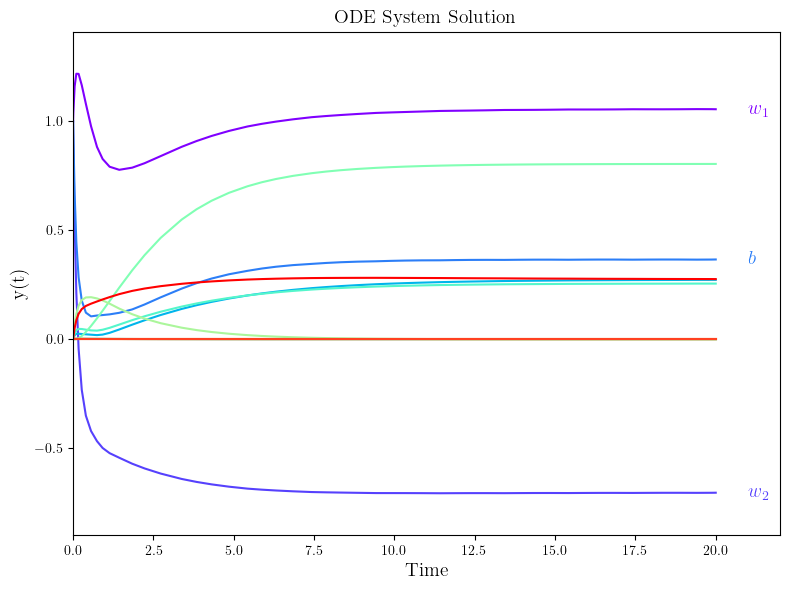

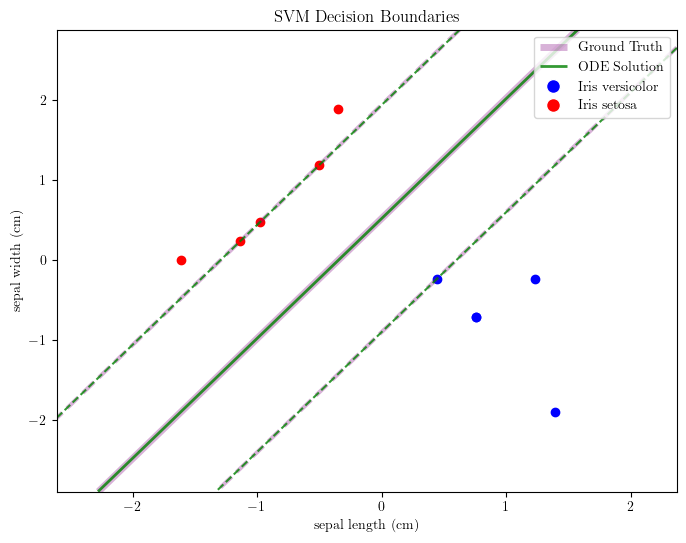

In [10]:
xu0 = jnp.zeros(NY)
xu0 = xu0.at[:nw + nb].set(1.0)

sol, result = solve_ODE(xu0, 20)

t_values = sol.t
y_values = sol.y

w_ode = result[:data_X.shape[1]]
b_ode = result[data_X.shape[1]]

plot_ode_system(t_values, y_values)

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w.value, b.value, w_ode, b_ode, 0, 1)

# 3. The method

In [11]:
T=20.0

In [12]:
def g_batch(x):
    w = x[:, :nw]  # Extract w for each sample in the batch
    b = x[:, nw]   # Extract b for each sample in the batch

    # Compute g for each batch sample (2048) and constraint (10) using NumPy
    g = [[-selected_y[j] * (w[i] @ selected_X[j] + b[i]) + 1 for j in range(selected_y.shape[0])] for i in range(x.shape[0])]
    
    output = np.array(g)
    return output

In [13]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x


class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()
            
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        t0 = time.time()
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                #print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
                pass
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i==ITERATIONS:
                break

        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time.time()-t0

    def loss_compute(self, t, net):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # 1. Dynamics loss
        # Compute loss, torch.tensor a float
        dynamics_loss = mse(dy, pdy) # [NBATCH, NY]
        dynamics_loss = torch.sum(dynamics_loss, axis=1) # [NBATCH]
        dynamics_loss = torch.exp(-WEIGTHING*((t / T).detach().reshape((-1, ))**2))*dynamics_loss  # proprity smaller t
        dynamics_loss = torch.mean(dynamics_loss, axis=0)
        
        # 2. Constraint violation penalty with smooth weighting
        FIXED_PENALTY = 1.0
        PENALTY_SCALE = 2.0
        epsilon = 1e-3
        
        x = y[:, :nx].cpu().detach().numpy()
        g_values = torch.tensor(g_batch(x)).cuda()
        
        penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
        
        logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()
        
        constraint_loss = torch.sum(logarithmic_penalty, axis=1) # [NBATCH]
        constraint_weight  = torch.exp(-WEIGTHING * ((1 - t / T).detach().reshape((-1,))**2))
        constraint_loss = constraint_weight * constraint_loss
        constraint_loss = torch.mean(constraint_loss)
        
        # 4. Total loss
        loss = dynamics_loss + constraint_loss * CONSTRAINT_WEIGHT
        
        return loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]


In [14]:
y0 = np.zeros(NY)
y0[:nw + nb] = 1.0

In [15]:
def try_layers(l_list, n, lr):
     NEURONS = n
     LR = lr
     res = []
     for l in l_list:
          LAYERS = l
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def try_neurons(n_list, l, lr):
     LAYERS = l
     LR = lr
     res = []
     for n in n_list:
          NEURONS = n
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def try_lr(lr_list, l, n):
     LAYERS = l
     NEURONS = n
     res = []
     for lr in lr_list:
          LR = lr
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          non_inifinty_ratio = len([num for num in L_epsilon_curr if not  np.isinf(num)]) / len(L_epsilon_curr)
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'ratio:', non_inifinty_ratio, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'mse': mse_, 'ratio': non_inifinty_ratio, 'time': time})
     return res

def plot_results(res, y_max=50):
    fig, axes = plt.subplots(1, len(res), figsize=(20, 6))
    y_min = 0
    for i in range(len(res)):
        # Plot on the first subplot
        axes[i].plot(res[i]['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
        axes[i].plot(res[i]['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
        axes[i].set_xlabel('iteration')
        axes[i].set_ylabel('OuC metric')
        axes[i].set_title(f'l={res[i]["layers"]}, n={res[i]["neurons"]}, lr={res[i]["lr"]}')
        axes[i].legend()
        axes[i].grid(True)
        axes[i].set_ylim(y_min, y_max)
        axes[i].set_xlim(0, ITERATIONS)
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    # Show the plot
    plt.show()

def plot_result_confrontation(res):
     plt.figure(figsize=(6, 5))
     for r in res:
          plt.plot(r['L_epsilon'], marker='o', linestyle='-', label=f'l={r["layers"]}, n={r["neurons"]}, lr={r["lr"]}', markersize=1)
     # Add labels, title, legend and grid
     plt.xlabel('iteration')
     plt.ylabel('OuC metric')
     plt.title('Numbers of layers')
     plt.legend()  # Show the legend to distinguish the datasets
     plt.grid(False)
     plt.show()

def plot_hyperplane(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     w_net = epsilon[0][:selected_X.shape[1]]
     b_net = epsilon[0][selected_X.shape[1]]
     # Plotting
     plt.figure(figsize=(10, 8))
     plt.scatter(selected_X[selected_y > 0][:, 0], selected_X[selected_y > 0][:, 1], c='b', label='Class 1')
     plt.scatter(selected_X[selected_y < 0][:, 0], selected_X[selected_y < 0][:, 1], c='r', label='Class -1')

     # Plot the decision boundary
     x_min, x_max = selected_X[:, 0].min() - 1, selected_X[:, 0].max() + 1
     y_min, y_max = selected_X[:, 1].min() - 1, selected_X[:, 1].max() + 1
     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
     Z = np.dot(np.c_[xx.ravel(), yy.ravel()], w_net) + b_net
     Z = Z.reshape(xx.shape)
     plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])

     # Plot the margins
     plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])

     plt.xlabel('Feature 1')
     plt.ylabel('Feature 2')
     plt.legend()
     plt.title('Hard Margin SVM Decision Boundary')
     plt.show()

def print_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     w_net = epsilon[0][:selected_X.shape[1]]  # All weights
     b_net = epsilon[0][selected_X.shape[1]]   # Bias

     # Calculate absolute differences for weights and bias
     w_abs_diff = np.abs(w_ode - w_net)         # Vector for all weights
     b_abs_diff = np.abs(b_ode - b_net)      # Single value for bias

     # Calculate squared differences
     w_sq_diff = w_abs_diff ** 2               # Vector for squared differences of weights
     b_sq_diff = b_abs_diff ** 2               # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = (np.sum(w_sq_diff) + b_sq_diff) / (len(w_sq_diff) + 1)

     # Print the absolute differences for all weights and bias
     print('w absolute differences:', w_abs_diff)
     print('b absolute difference:', b_abs_diff)

     # Print the MSE
     print('\nMSE between the two solutions:', mse_)

def get_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]], dtype=torch.float32).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     w_net = epsilon[0][:selected_X.shape[1]]  # All weights
     b_net = epsilon[0][selected_X.shape[1]]   # Bias

     # Calculate absolute differences for weights and bias
     w_abs_diff = np.abs(w_ode - w_net)         # Vector for all weights
     b_abs_diff = np.abs(b_ode - b_net)      # Single value for bias

     # Calculate squared differences
     w_sq_diff = w_abs_diff ** 2               # Vector for squared differences of weights
     b_sq_diff = b_abs_diff ** 2               # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = (np.sum(w_sq_diff) + b_sq_diff) / (len(w_sq_diff) + 1)

     return mse_

In [16]:
T=20.0
NBATCH = 512
ITERATIONS = 1000
NEURONS=100
LR=0.01
LAYERS=2
hyperparameter_combinations = []

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.96719265 MSE solution: 0.008253852626246514 ratio: 0.073 time: 58.75770711898804
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9231147 MSE solution: 0.0052585297555961105 ratio: 0.109 time: 63.75997710227966
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.83938193 MSE solution: 0.0003231025066608182 ratio: 0.128 time: 58.09684777259827
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.85079306 MSE solution: 0.0004350353693309003 ratio: 0.128 time: 57.00423765182495
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.84059614 MSE solution: 0.0003095352530881415 ratio: 0.177 time: 57.64493203163147
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 11.526676 MSE solution: 6.589624591781317 ratio: 0.023 time: 60.2341570854187
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9499142 MSE solution: 0.011994013844781022 ratio: 0.046 time: 55.483694314956665
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8592778 MSE solution: 0.0022462710713201466 ratio: 0.184 time: 56.19112491607666
LAYERS: 2 

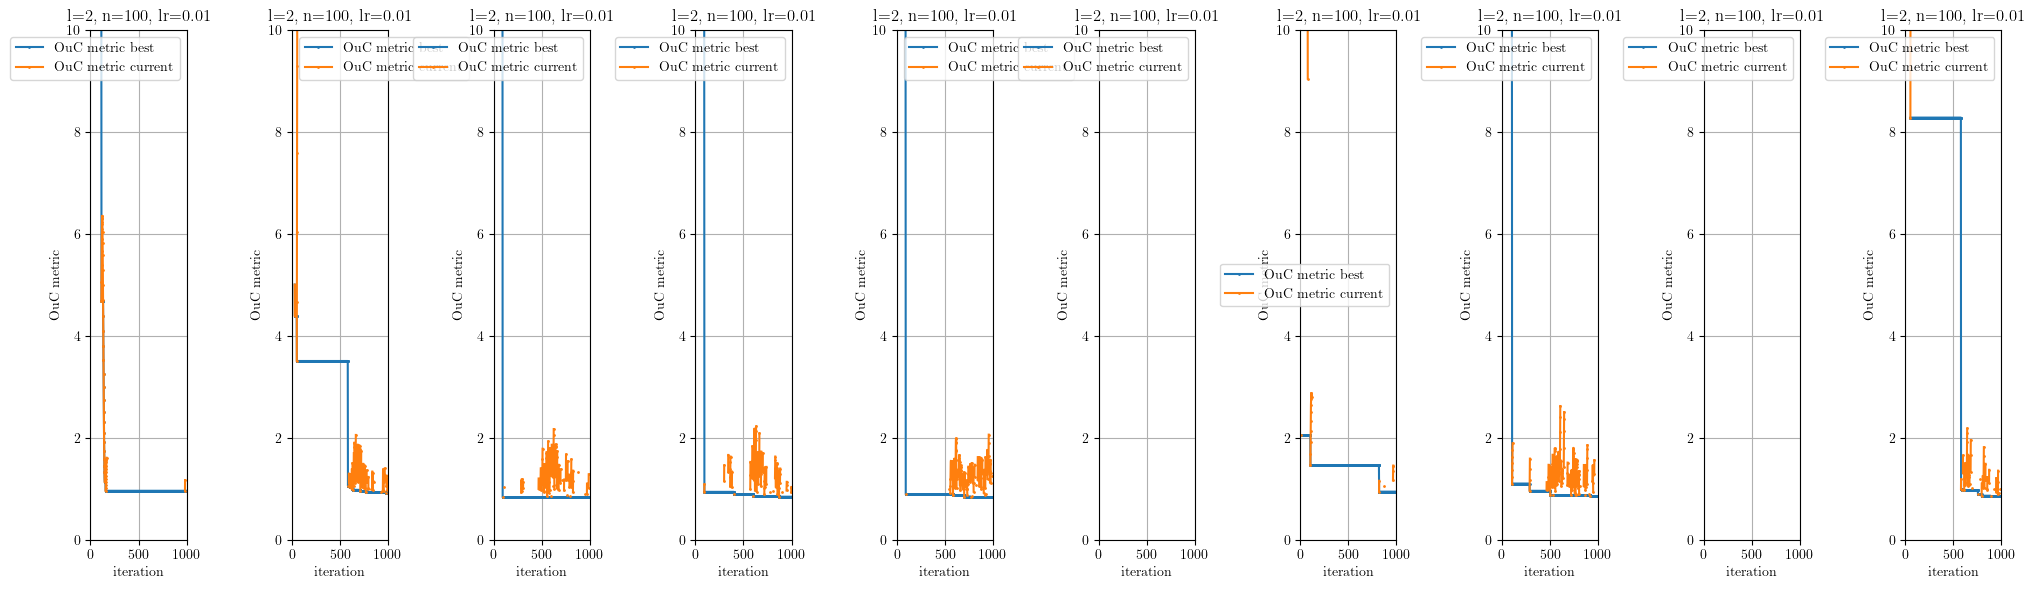

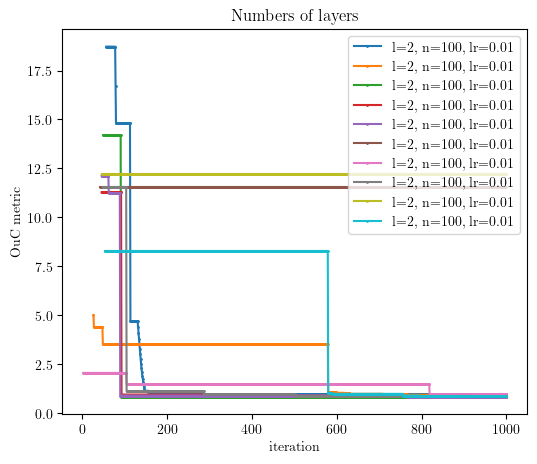

In [17]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8454116 MSE solution: 0.0005692950088954102 ratio: 0.13 time: 57.624828815460205
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.351953 MSE solution: 0.3937426095316894 ratio: 0.039 time: 52.80049252510071
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.84535813 MSE solution: 0.0004444911463797749 ratio: 0.114 time: 54.205002307891846
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9256238 MSE solution: 0.010607950621743101 ratio: 0.077 time: 53.50946879386902
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.0030863 MSE solution: 0.012499417862457679 ratio: 0.033 time: 53.74457836151123
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8594435 MSE solution: 0.0022767341554485424 ratio: 0.078 time: 55.889962673187256
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.90004915 MSE solution: 0.001906994302443509 ratio: 0.102 time: 58.54024147987366
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8897392 MSE solution: 0.0023671567264890118 ratio: 0.105 time: 54.3745436668396
LAYERS: 2 NE

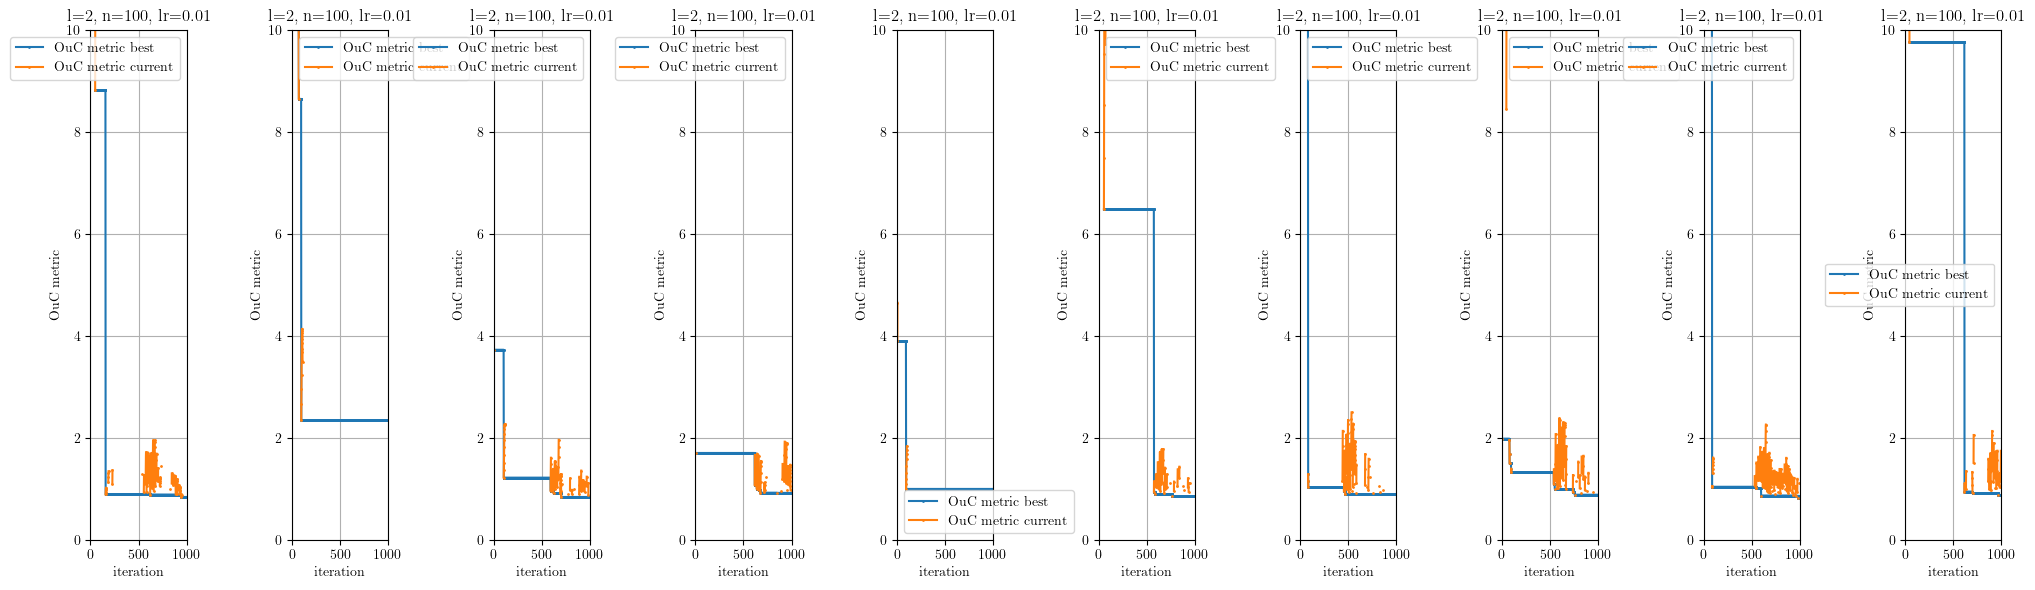

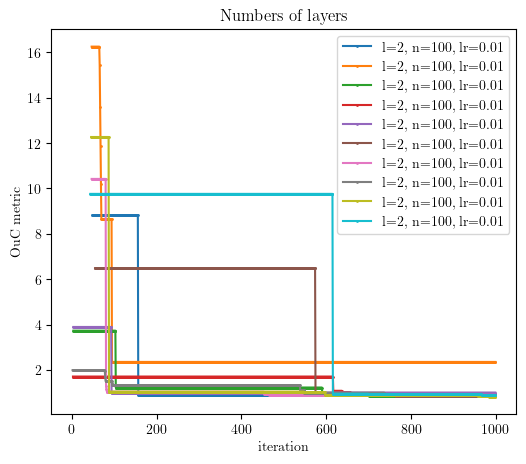

In [18]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.87541175 MSE solution: 0.0012204469399709748 ratio: 0.058 time: 53.57187366485596
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9018771 MSE solution: 0.0032251995695182704 ratio: 0.072 time: 55.53659749031067
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8621292 MSE solution: 0.0010396664226110465 ratio: 0.055 time: 57.539817810058594
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8538024 MSE solution: 0.001218432564089967 ratio: 0.049 time: 57.41632294654846
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8494479 MSE solution: 0.0009859419600284707 ratio: 0.193 time: 56.25544714927673
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.861212 MSE solution: 0.0008152547811607195 ratio: 0.09 time: 59.91791772842407
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8532829 MSE solution: 0.0008427271106485075 ratio: 0.047 time: 58.716904401779175
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.86118484 MSE solution: 0.0008036935817004675 ratio: 0.092 time: 61.612621784210205
LAYERS

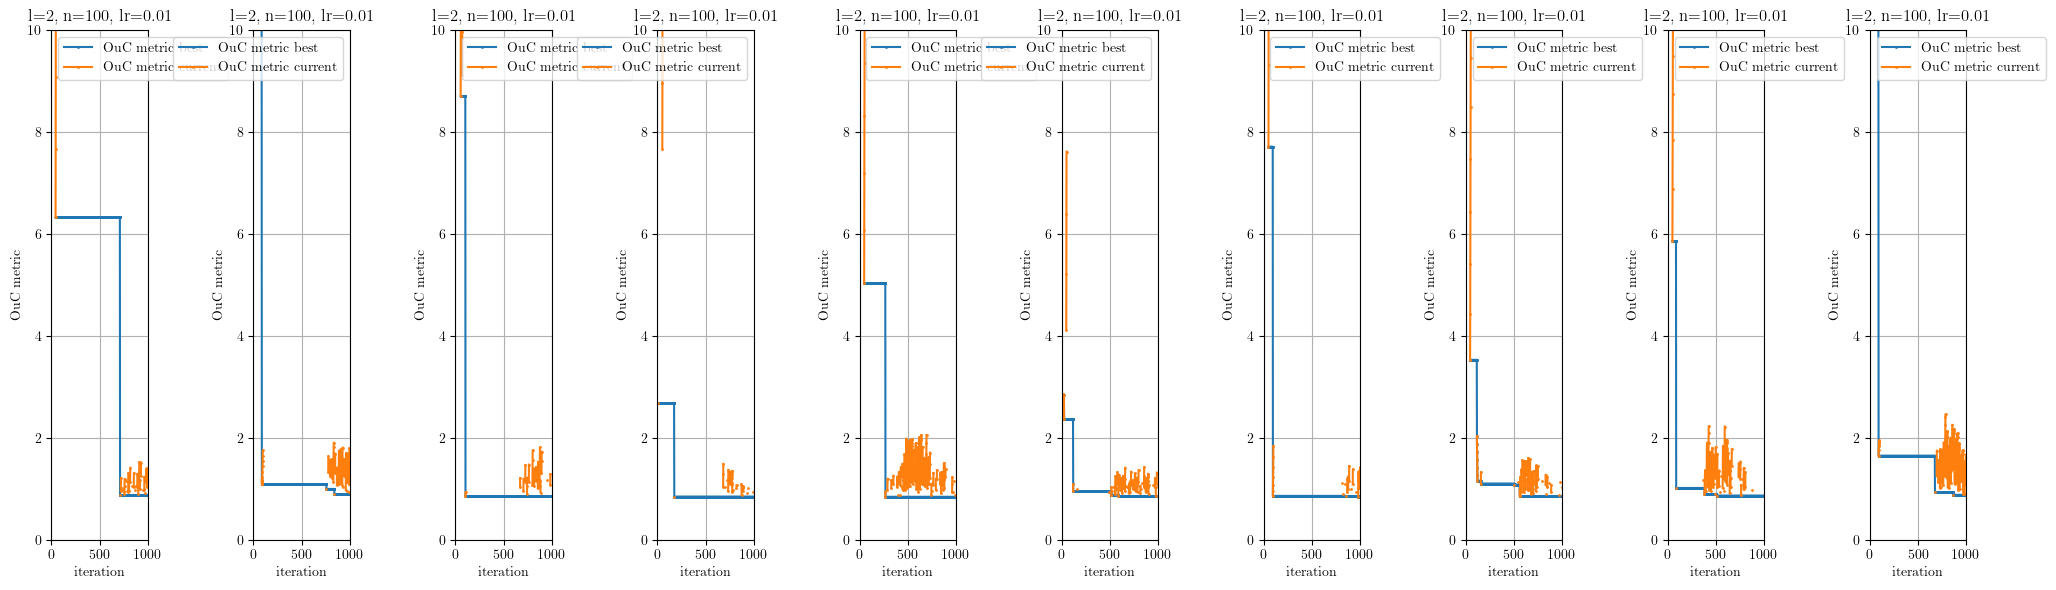

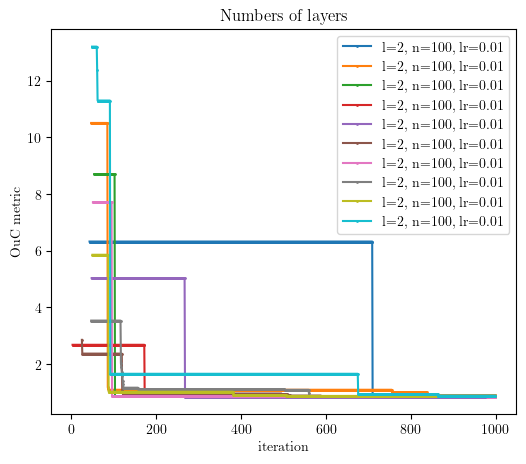

In [19]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9549926 MSE solution: 0.016435250713349583 ratio: 0.033 time: 62.3450813293457
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.85509366 MSE solution: 0.0005478431332875991 ratio: 0.261 time: 60.67133569717407
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.96636784 MSE solution: 0.013723560834926513 ratio: 0.046 time: 59.45789074897766
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.92344934 MSE solution: 0.003765863821016407 ratio: 0.069 time: 59.66786766052246
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8599576 MSE solution: 0.0006775880861319398 ratio: 0.17 time: 57.96676754951477
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9014388 MSE solution: 0.0034853422410121844 ratio: 0.121 time: 54.13427996635437
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.89057934 MSE solution: 0.003219268183295205 ratio: 0.047 time: 56.57003903388977
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.85062313 MSE solution: 0.0007240611254221693 ratio: 0.072 time: 56.811354875564575
LAYERS: 

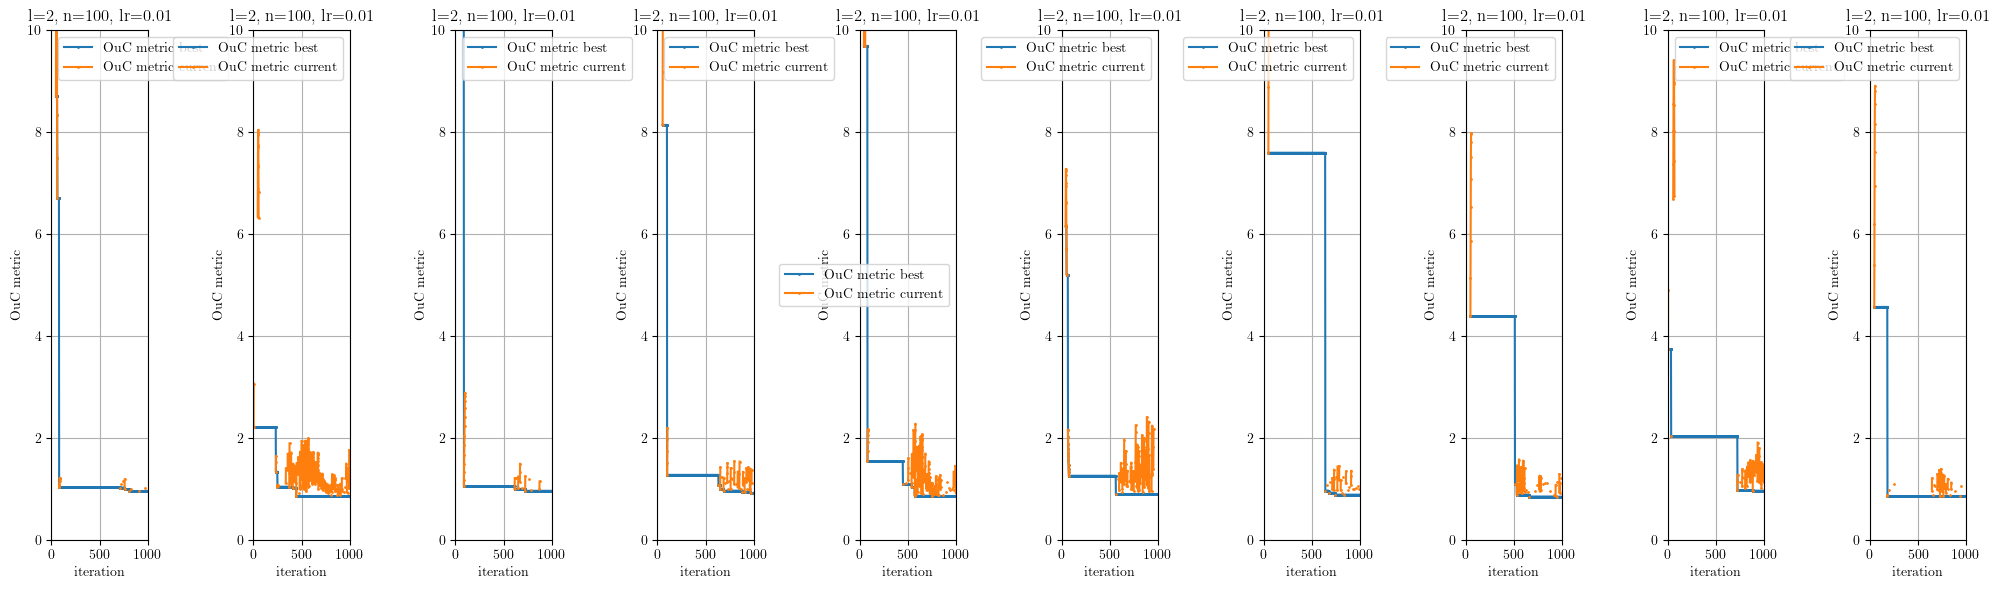

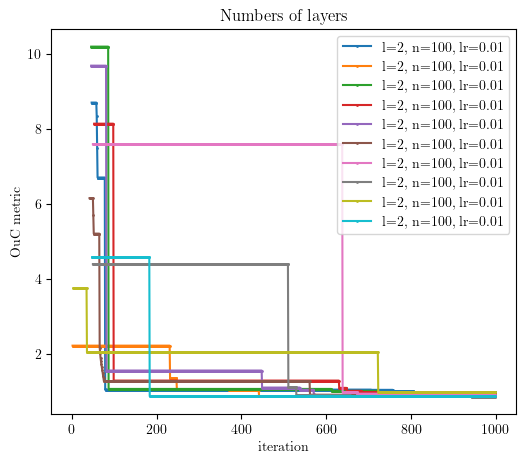

In [20]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.95345217 MSE solution: 0.008320517189335607 ratio: 0.03 time: 52.238030672073364
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9833813 MSE solution: 0.008839957629685391 ratio: 0.028 time: 53.32017517089844
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.92735493 MSE solution: 0.0046884694140719675 ratio: 0.133 time: 54.29945683479309
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.86828494 MSE solution: 0.0008592815269750668 ratio: 0.126 time: 53.2334885597229
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.90137106 MSE solution: 0.004389332819331951 ratio: 0.104 time: 54.02529454231262
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8548397 MSE solution: 0.0014328746925970524 ratio: 0.127 time: 52.132288694381714
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9889903 MSE solution: 0.007361825196440366 ratio: 0.046 time: 53.094277143478394
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5788863 MSE solution: 0.13065530519037474 ratio: 0.027 time: 51.76351737976074
LAYERS: 2

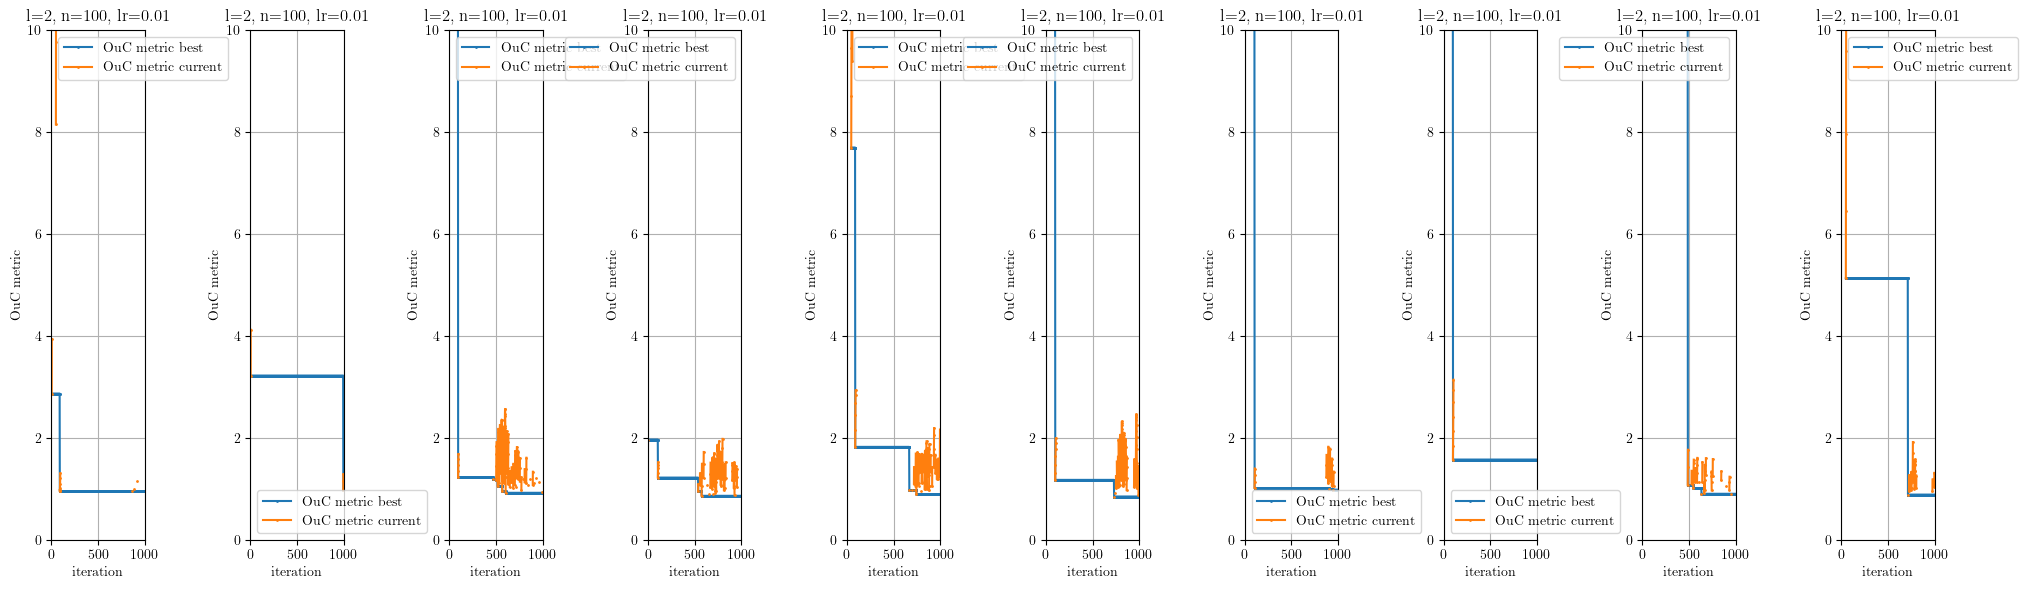

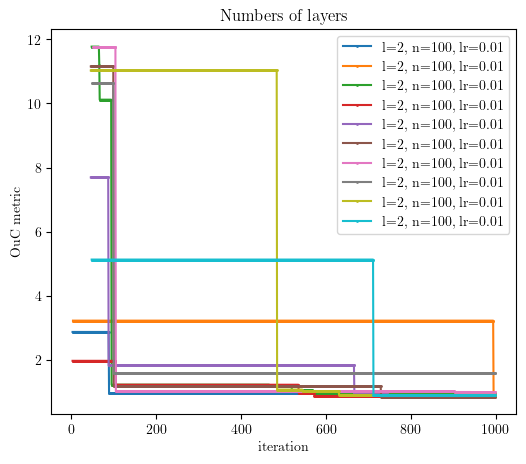

In [21]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 5.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.86639774 MSE solution: 0.0022773033851271516 ratio: 0.031 time: 54.52220010757446
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.0848932 MSE solution: 0.02964597876280695 ratio: 0.03 time: 53.681161642074585
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8692753 MSE solution: 0.00253501349952091 ratio: 0.121 time: 55.965160608291626
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.99528056 MSE solution: 0.010025242066523063 ratio: 0.021 time: 55.98391246795654
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9730893 MSE solution: 0.010594184845153816 ratio: 0.051 time: 54.446030616760254
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8720689 MSE solution: 0.0029323920995589447 ratio: 0.119 time: 55.917670249938965
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.86689544 MSE solution: 0.0014465823142989652 ratio: 0.054 time: 56.55502986907959
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8792314 MSE solution: 0.0011921068644554736 ratio: 0.092 time: 54.549681186676025
LAYERS:

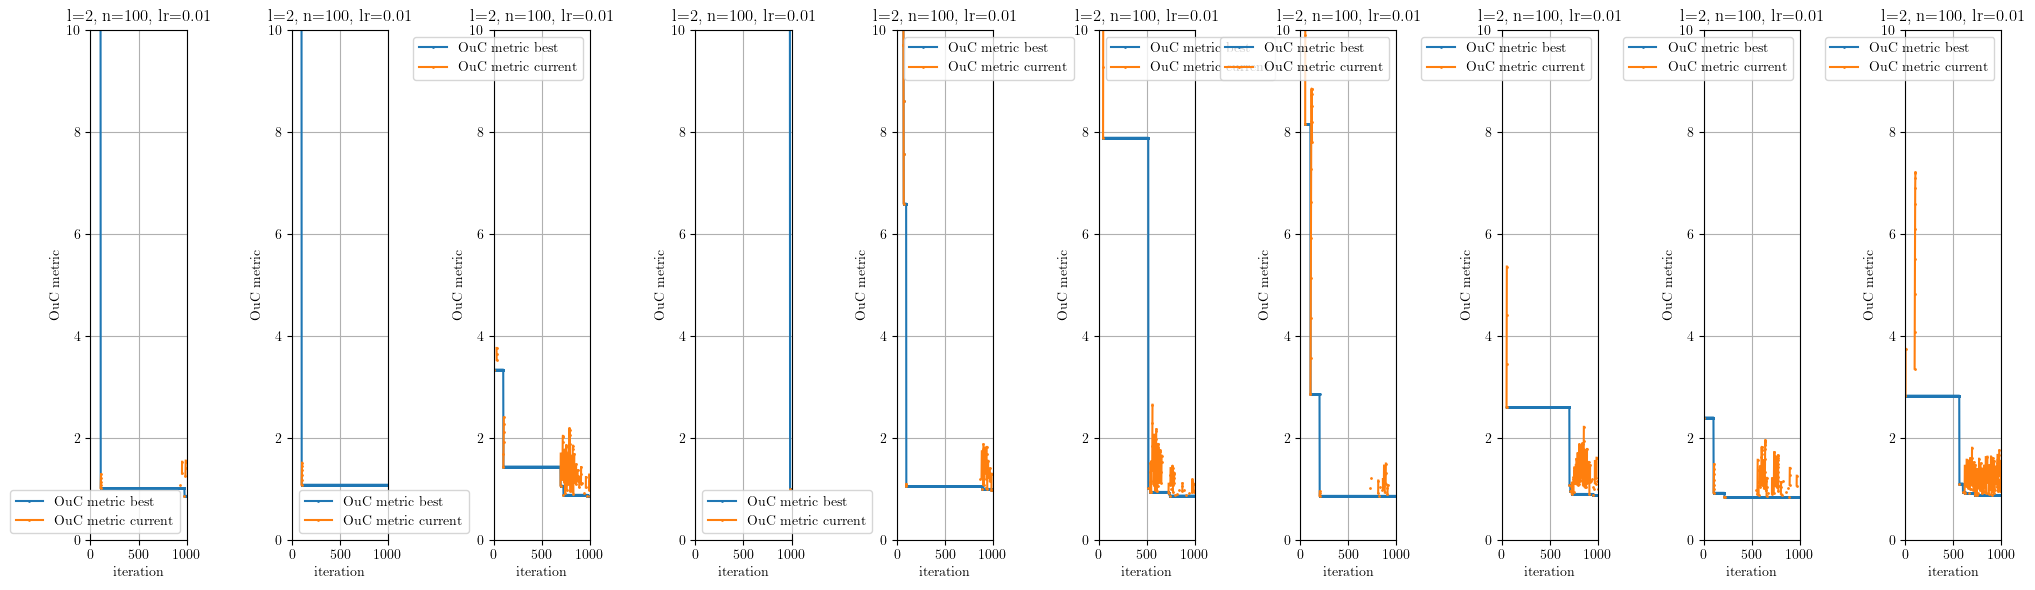

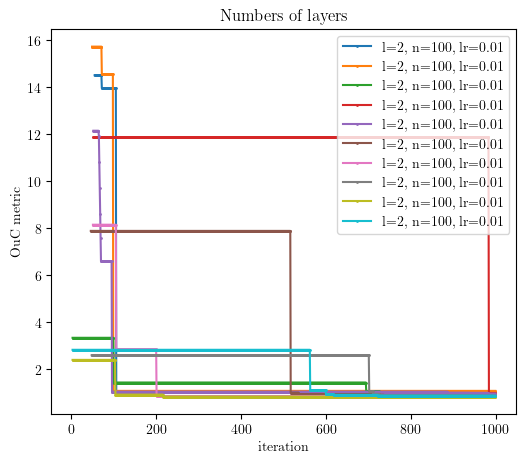

In [22]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 10.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8372167 MSE solution: 0.0010893883884628486 ratio: 0.132 time: 54.38409996032715
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.89531446 MSE solution: 0.006342783609142475 ratio: 0.115 time: 54.87363648414612
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.86783195 MSE solution: 0.0011320656619379873 ratio: 0.165 time: 53.8675103187561
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9006516 MSE solution: 0.0019611527638931244 ratio: 0.024 time: 53.092103719711304
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.89202976 MSE solution: 0.002447358490414816 ratio: 0.152 time: 51.62853121757507
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9119578 MSE solution: 0.006626718017971091 ratio: 0.097 time: 54.328654050827026
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8759237 MSE solution: 0.0032228216747460757 ratio: 0.167 time: 54.03243947029114
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8920672 MSE solution: 0.0034630283035763706 ratio: 0.039 time: 56.13449668884277
LAYERS:

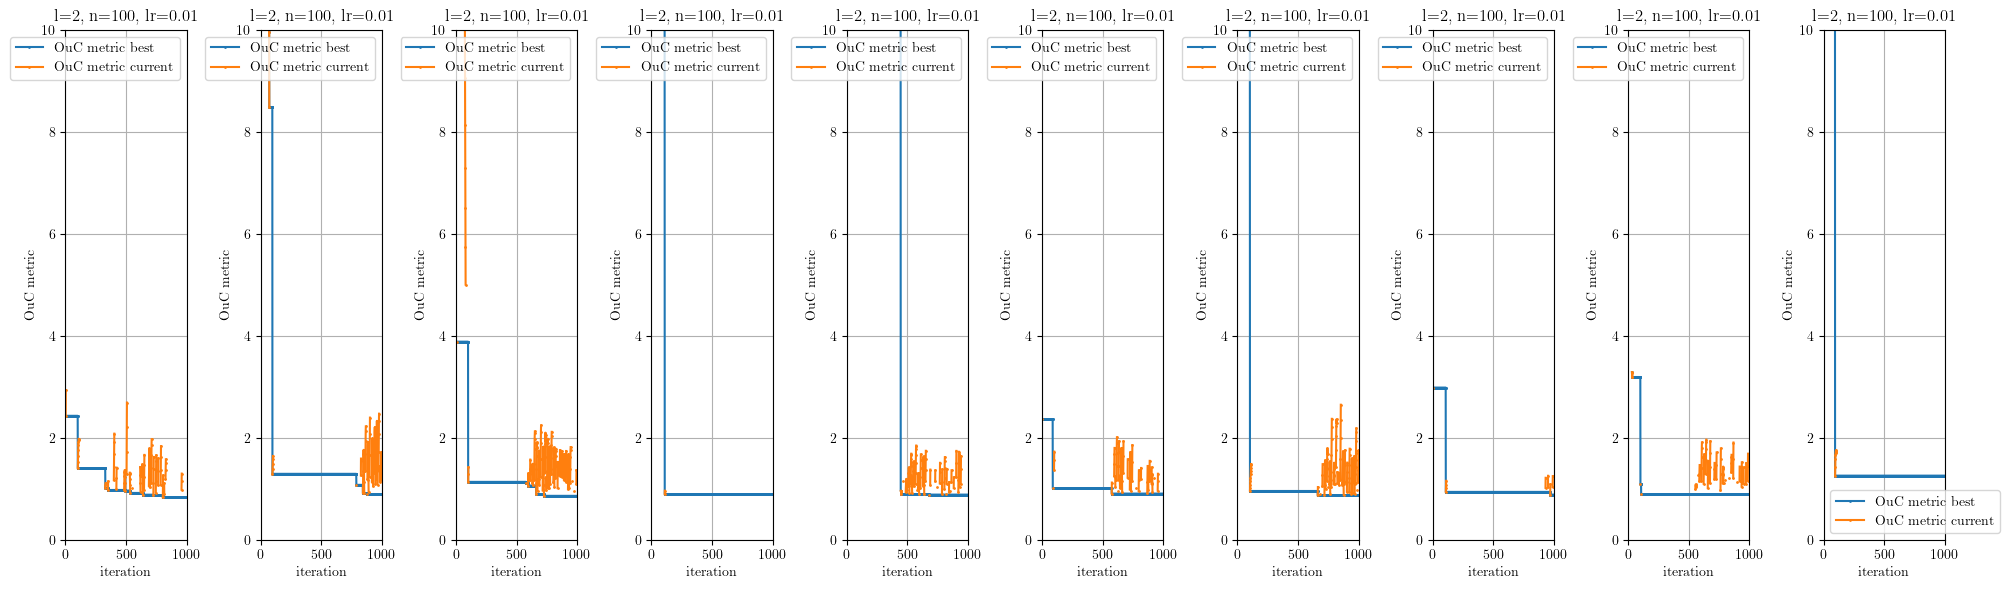

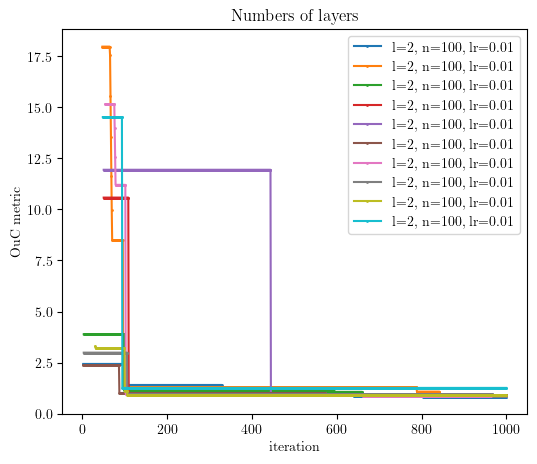

In [23]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 20.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8924486 MSE solution: 0.002904691700136285 ratio: 0.106 time: 56.33030366897583
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.847317 MSE solution: 0.001589816754645362 ratio: 0.137 time: 56.0530846118927
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9053745 MSE solution: 0.0025193464305538773 ratio: 0.121 time: 53.773001194000244
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8467905 MSE solution: 0.00045092035125690166 ratio: 0.12 time: 54.44708061218262
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.90959144 MSE solution: 0.004068788077261304 ratio: 0.091 time: 54.35308122634888
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9252229 MSE solution: 0.004700525257143608 ratio: 0.053 time: 56.344720125198364
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.91604406 MSE solution: 0.0029950438819788656 ratio: 0.134 time: 52.54508566856384
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8870853 MSE solution: 0.007325583426050099 ratio: 0.145 time: 55.09214735031128
LAYERS: 2 N

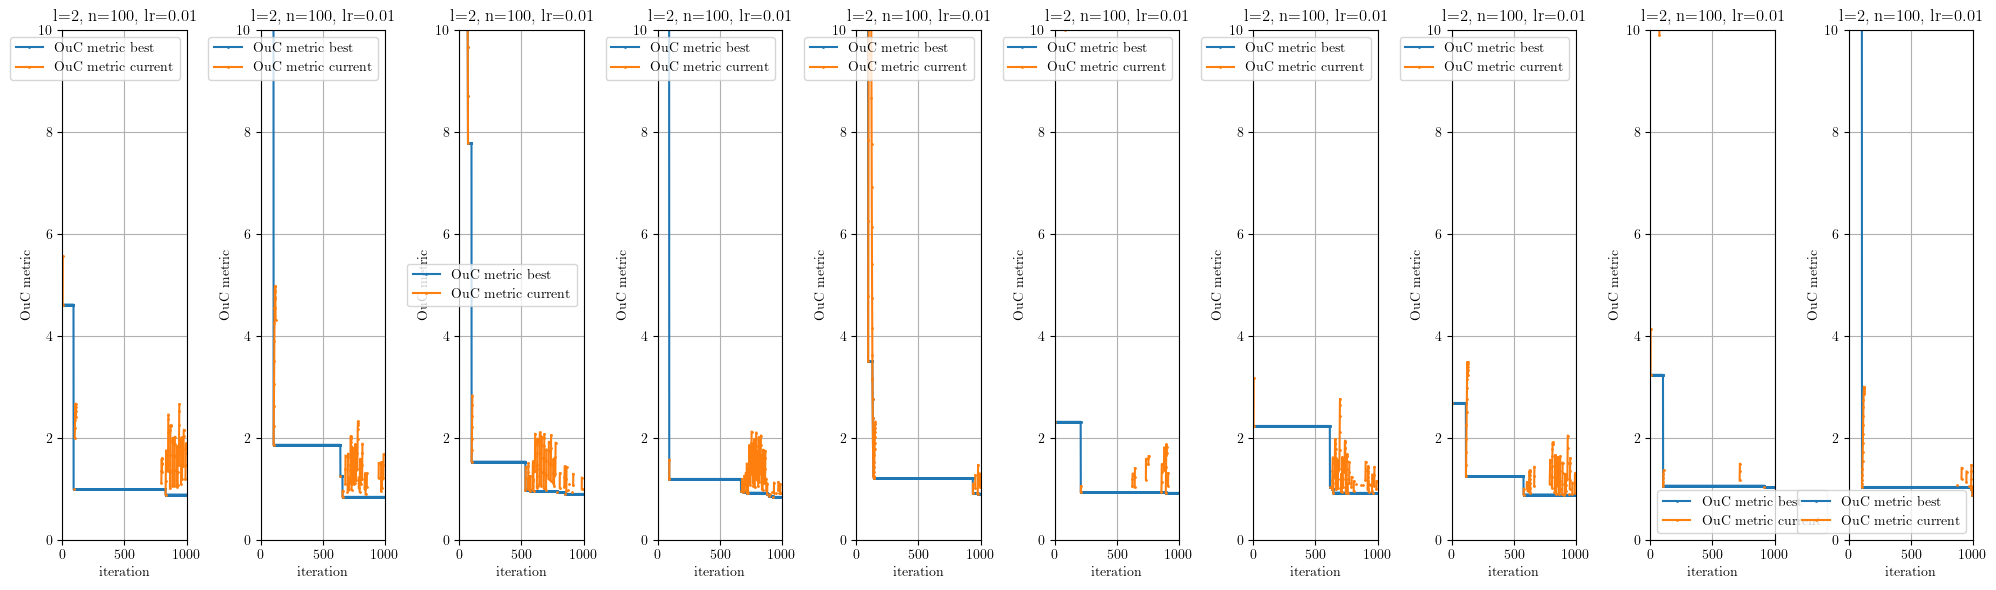

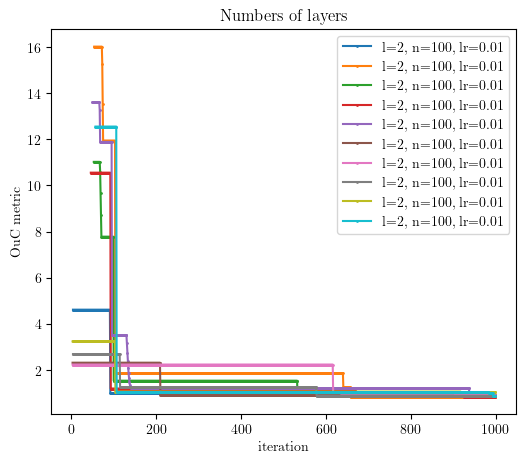

In [24]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 50.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9147617 MSE solution: 0.004469589448969664 ratio: 0.101 time: 52.4928994178772
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8294207 MSE solution: 0.00035175511670594177 ratio: 0.053 time: 53.6774263381958
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.86920357 MSE solution: 0.0019501379597169721 ratio: 0.078 time: 52.68295097351074
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8435852 MSE solution: 0.0004874978552347529 ratio: 0.128 time: 55.83039379119873
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9740617 MSE solution: 0.012133251112993898 ratio: 0.039 time: 52.63429045677185
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8960711 MSE solution: 0.002976410959830956 ratio: 0.056 time: 53.308106899261475
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.82432497 MSE solution: 0.00028518736072629286 ratio: 0.11 time: 54.009066343307495
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.3612796 MSE solution: 0.06361052381512126 ratio: 0.025 time: 52.521801471710205
LAYERS: 2

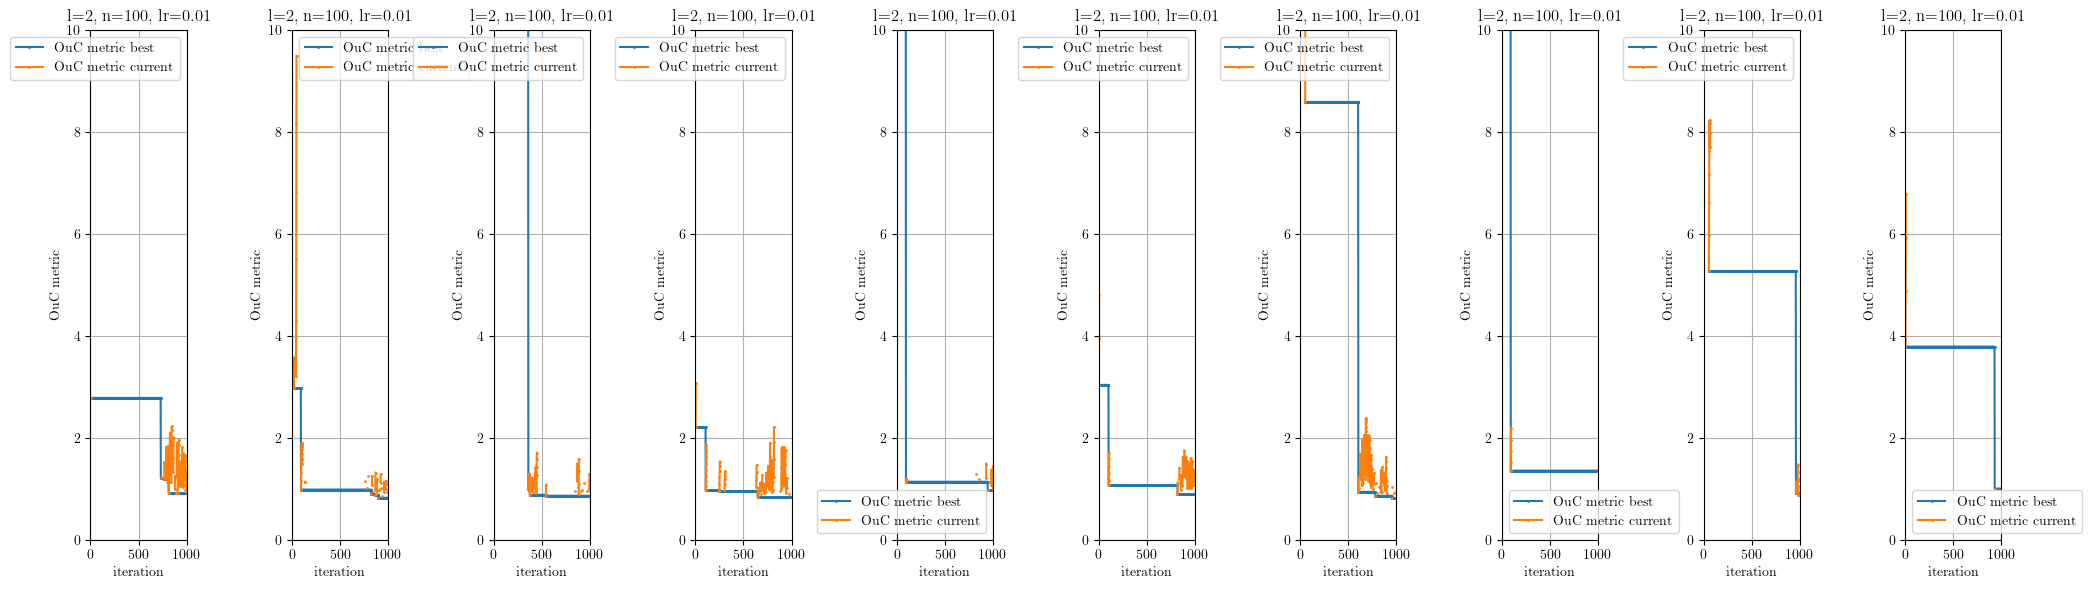

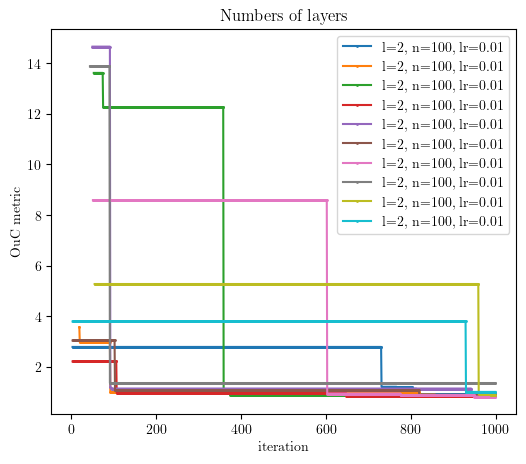

In [25]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 100.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.91176313 MSE solution: 0.005232852749857564 ratio: 0.119 time: 54.32688641548157
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.87903994 MSE solution: 0.0019681930406429565 ratio: 0.103 time: 51.94591689109802
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.89029616 MSE solution: 0.002027731267676193 ratio: 0.162 time: 54.570287227630615
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 12.353274 MSE solution: 5.6462777508663455 ratio: 0.02 time: 53.83065342903137
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8464875 MSE solution: 0.00044593725715688783 ratio: 0.149 time: 51.55469632148743
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9063675 MSE solution: 0.009967362555121335 ratio: 0.049 time: 52.56365370750427
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8855761 MSE solution: 0.0034594615612626896 ratio: 0.102 time: 49.60060143470764
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8521012 MSE solution: 0.0005399022536641394 ratio: 0.074 time: 54.29443359375
LAYERS: 2 NEU

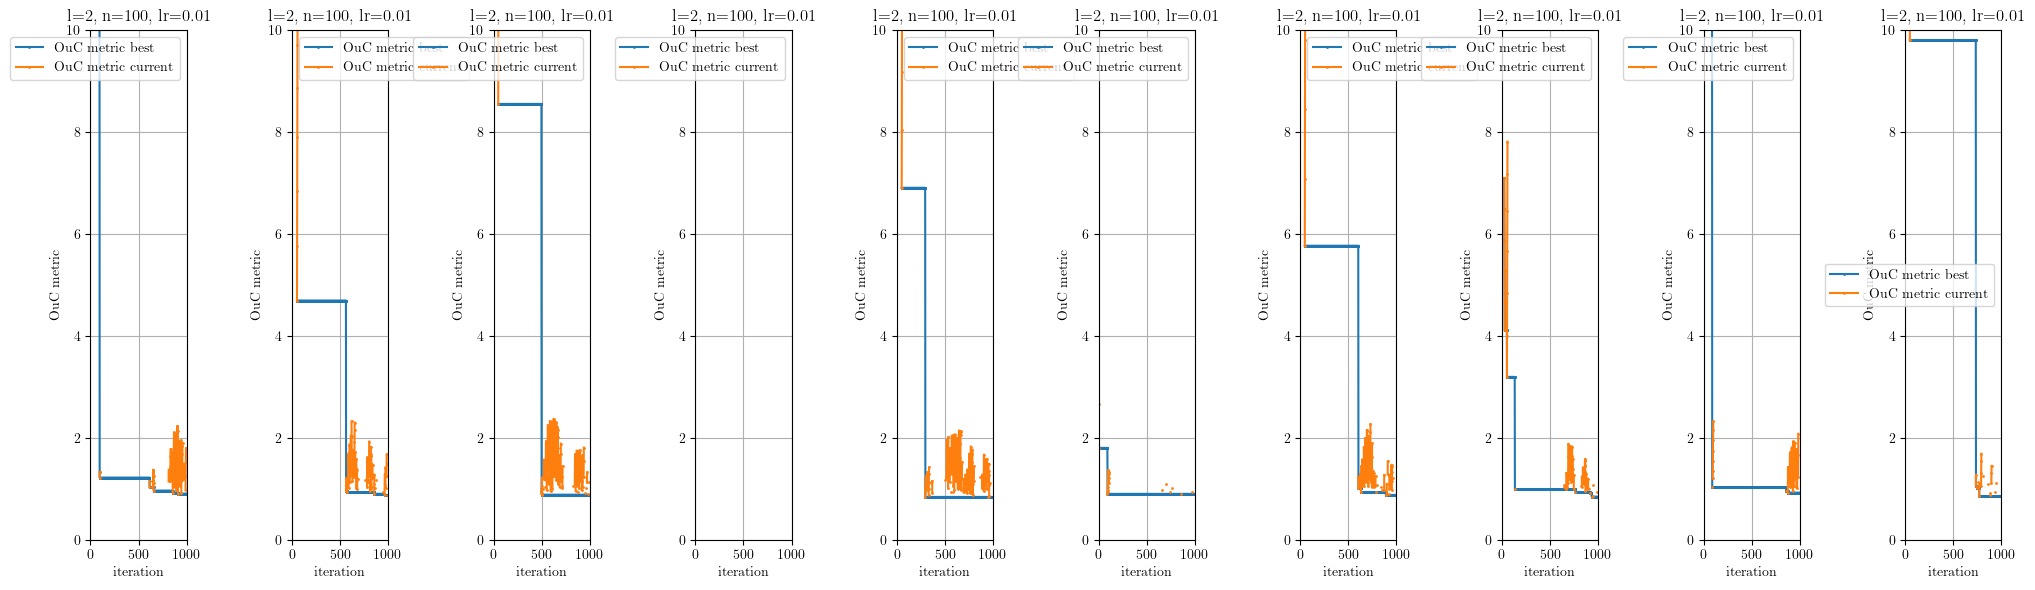

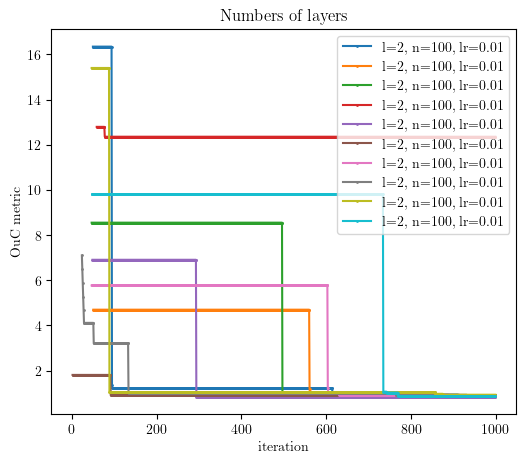

In [26]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 200.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8474467 MSE solution: 0.0005051520107549715 ratio: 0.108 time: 53.48118758201599
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.91325295 MSE solution: 0.00469676820777288 ratio: 0.037 time: 55.937416076660156
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.056838 MSE solution: 0.01560698876608968 ratio: 0.046 time: 54.35445785522461
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8395894 MSE solution: 0.00024797504155781524 ratio: 0.086 time: 53.836652517318726
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.85650474 MSE solution: 0.0020249706139615787 ratio: 0.122 time: 52.11693739891052
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8940456 MSE solution: 0.0020465624347392746 ratio: 0.059 time: 51.61026740074158
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8456165 MSE solution: 0.0014462194392124092 ratio: 0.052 time: 57.12449073791504
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.87158376 MSE solution: 0.003960398337153292 ratio: 0.06 time: 57.12475037574768
LAYERS: 2

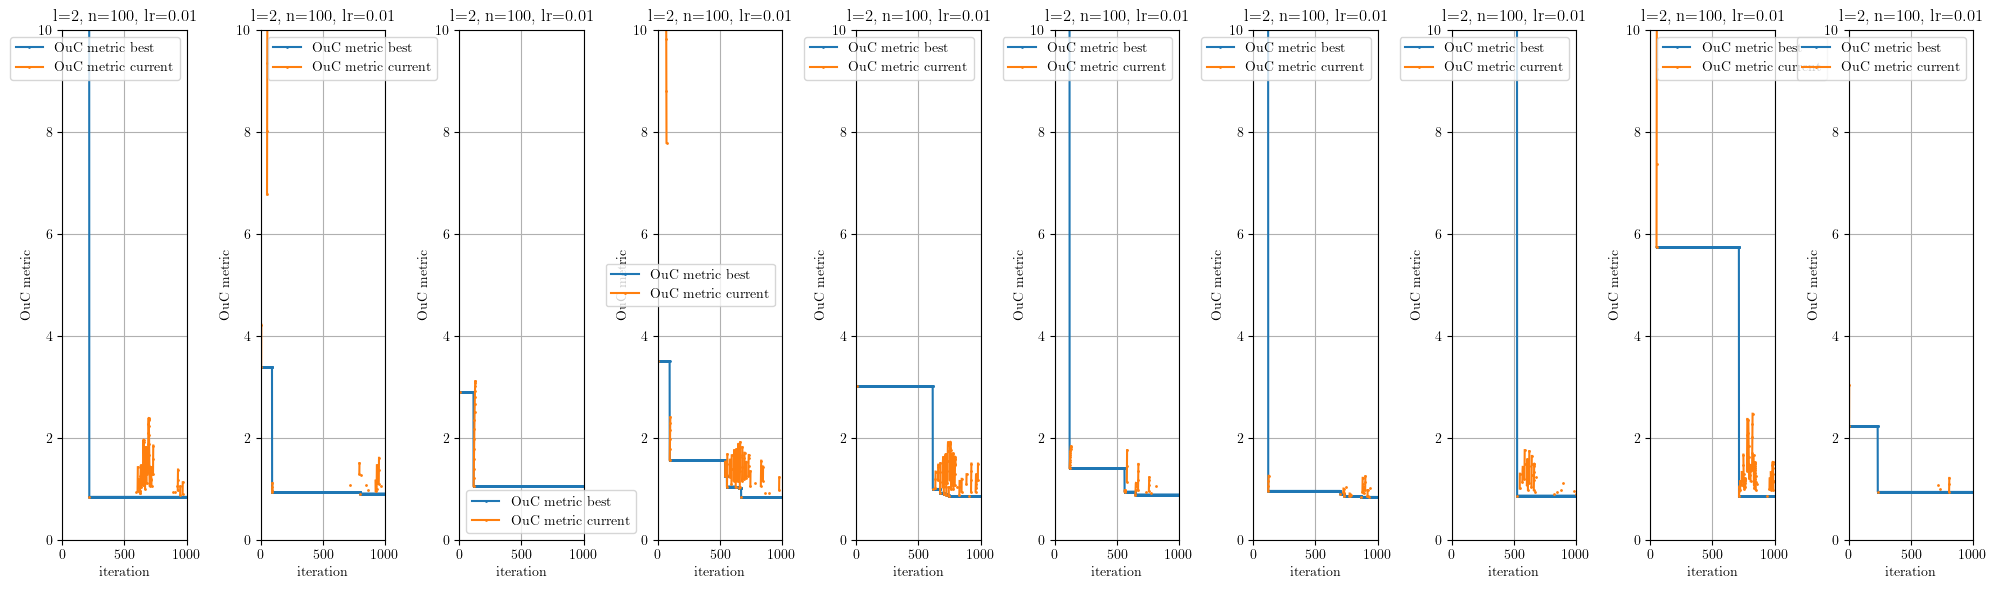

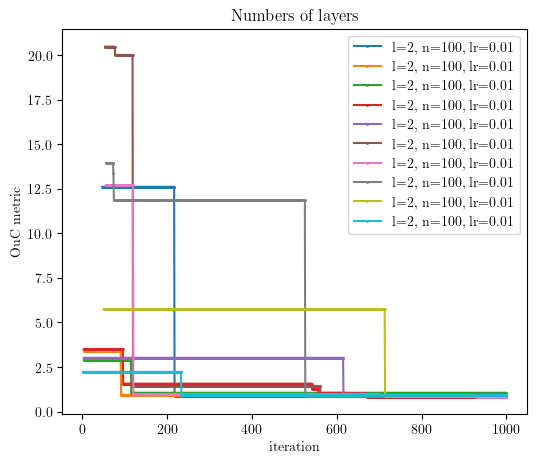

In [27]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 500.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.1514709 MSE solution: 0.02660646128852225 ratio: 0.025 time: 54.73279285430908
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.87200433 MSE solution: 0.0016846834555929167 ratio: 0.11 time: 57.64029550552368
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.85681134 MSE solution: 0.0014165871072832515 ratio: 0.221 time: 54.72458267211914
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.855436 MSE solution: 0.000585004563142541 ratio: 0.14 time: 57.358325242996216
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.85150063 MSE solution: 0.000902202080557574 ratio: 0.086 time: 59.80846405029297
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8883065 MSE solution: 0.006098218623660795 ratio: 0.024 time: 53.80223751068115
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8997603 MSE solution: 0.007591239776460669 ratio: 0.09 time: 51.2741813659668
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9020638 MSE solution: 0.0026652696577835924 ratio: 0.102 time: 59.15967130661011
LAYERS: 2 NEURO

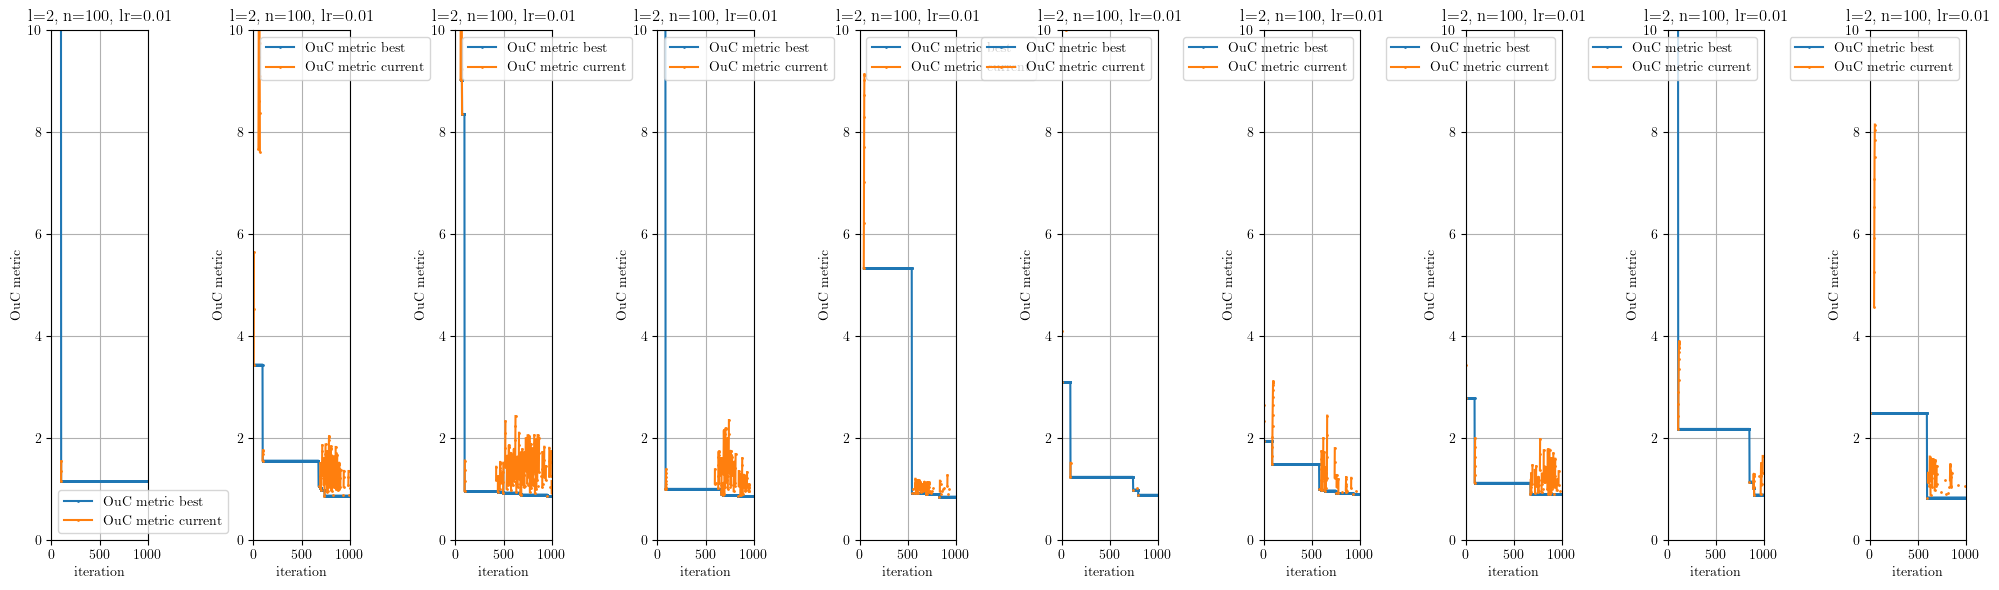

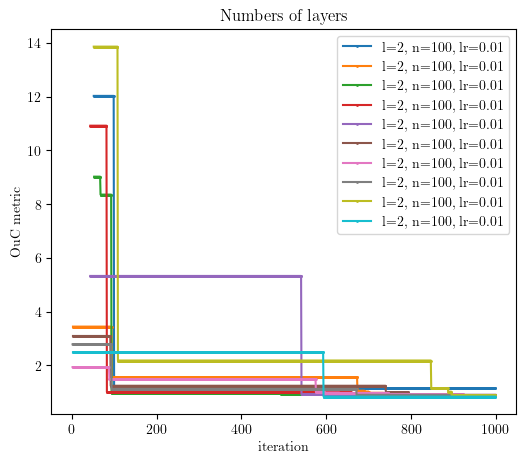

In [28]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 5.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8523952 MSE solution: 0.000592257475344705 ratio: 0.12 time: 58.391345739364624
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.90025467 MSE solution: 0.0028477333226893495 ratio: 0.046 time: 54.81579351425171
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.83143204 MSE solution: 0.00029211987300669897 ratio: 0.108 time: 58.82905077934265
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.97986996 MSE solution: 0.019006598639441517 ratio: 0.023 time: 53.89814805984497
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.860726 MSE solution: 0.0006574120472296294 ratio: 0.057 time: 58.29239583015442
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8310245 MSE solution: 0.00029012512196362493 ratio: 0.148 time: 52.62967848777771
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9143724 MSE solution: 0.0055873788949166074 ratio: 0.052 time: 58.793248891830444
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.88359123 MSE solution: 0.0016759448936006349 ratio: 0.174 time: 57.45695900917053
LAYE

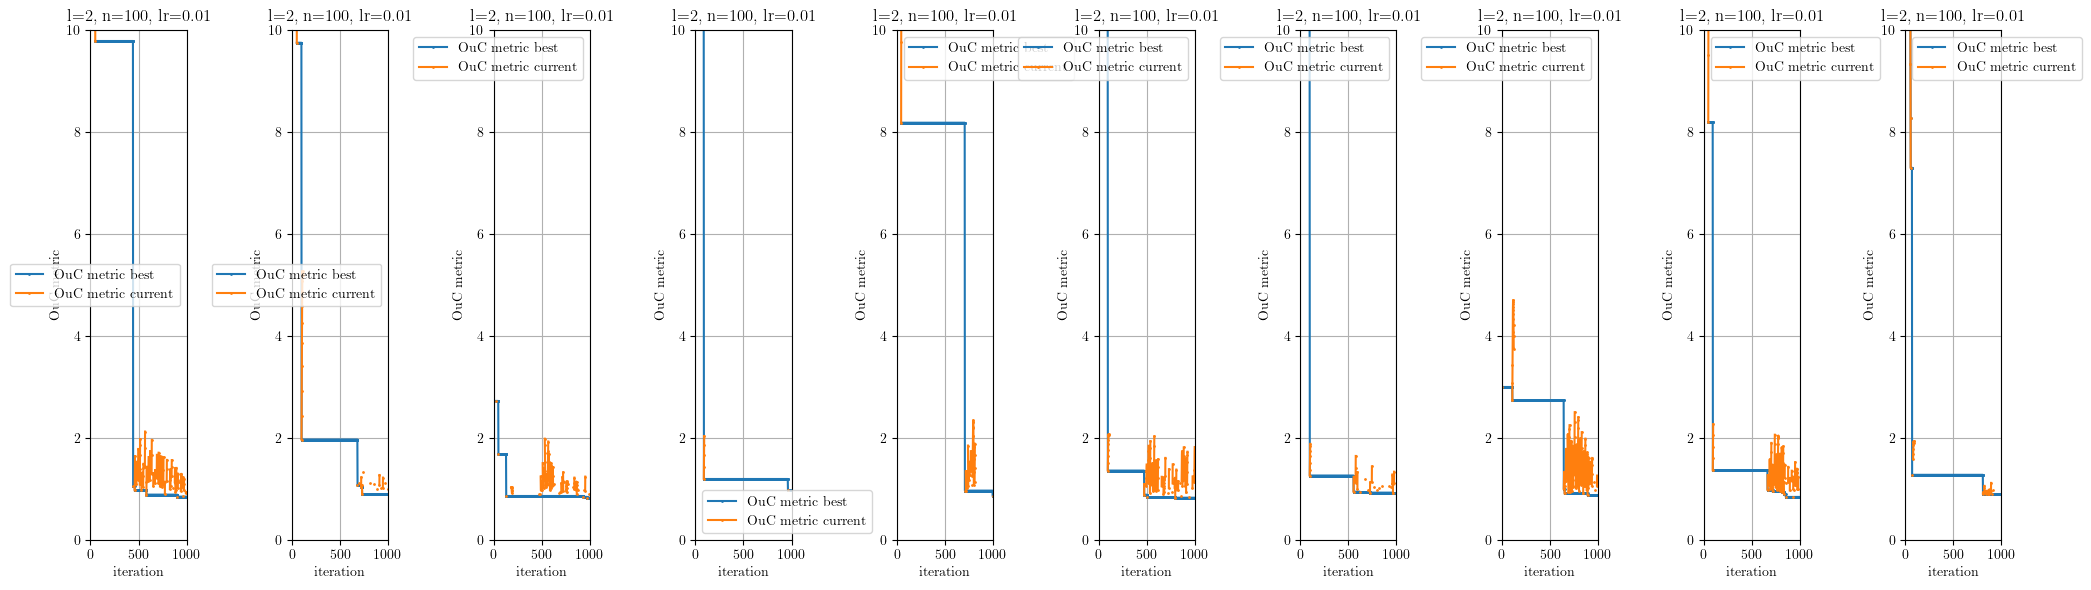

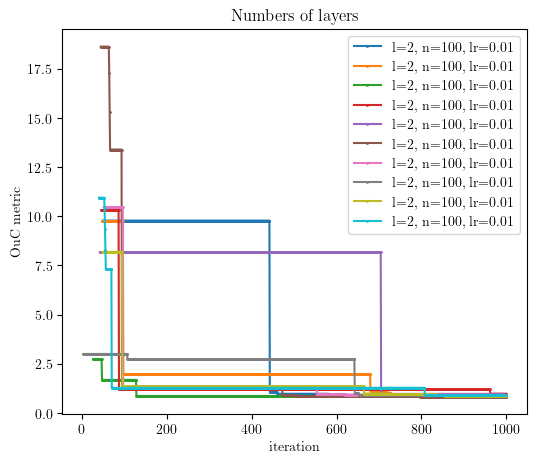

In [29]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 10.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9057037 MSE solution: 0.006396787942735817 ratio: 0.145 time: 57.690154790878296
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8499699 MSE solution: 0.0005928664485758229 ratio: 0.174 time: 54.427072286605835
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.880449 MSE solution: 0.0027575458259708192 ratio: 0.18 time: 58.05613088607788
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.83323604 MSE solution: 0.0003091979257617609 ratio: 0.065 time: 57.56143760681152
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8539195 MSE solution: 0.0007281116268433302 ratio: 0.064 time: 58.21239995956421
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.893552 MSE solution: 0.0021240624268897535 ratio: 0.143 time: 52.34583067893982
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.87202924 MSE solution: 0.0023069185008503163 ratio: 0.131 time: 53.30602288246155
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9125679 MSE solution: 0.008828922712674632 ratio: 0.051 time: 54.97703003883362
LAYERS: 2

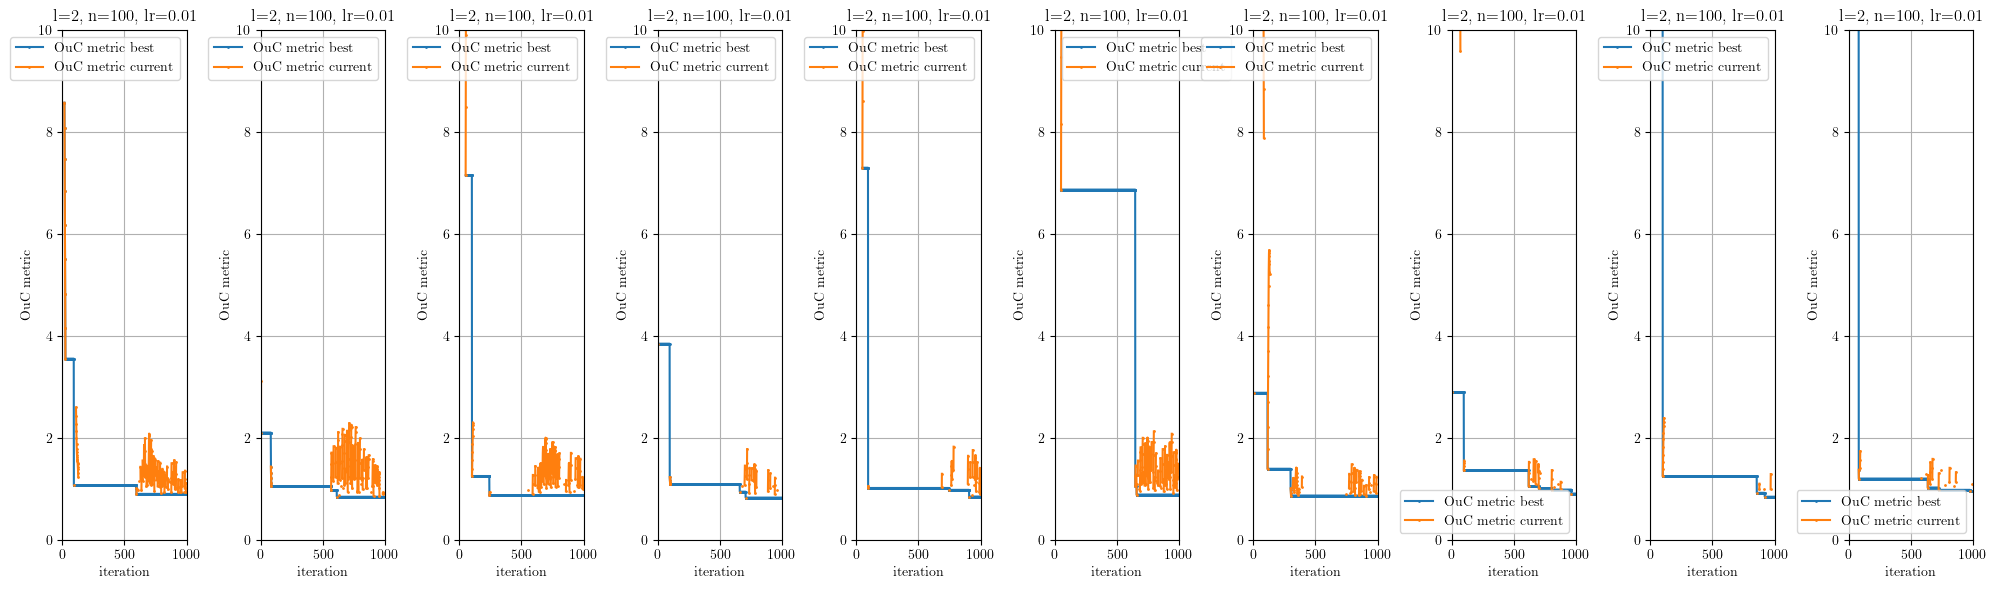

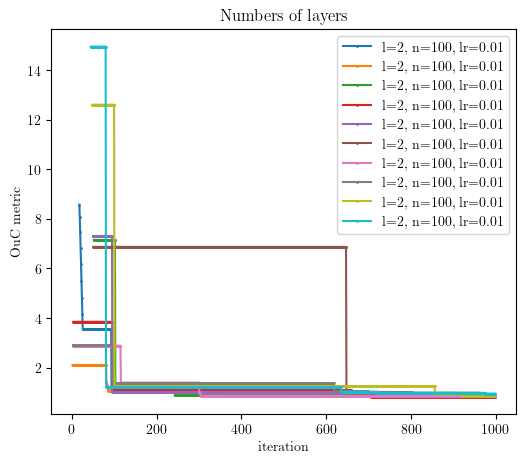

In [30]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 20.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8659895 MSE solution: 0.0008864122441012318 ratio: 0.021 time: 53.16359901428223
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.87815535 MSE solution: 0.002953335023918027 ratio: 0.083 time: 53.149770975112915
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8729873 MSE solution: 0.0032496398819175064 ratio: 0.189 time: 52.27286720275879
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.96351326 MSE solution: 0.006780932051051303 ratio: 0.07 time: 51.83112454414368
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8801082 MSE solution: 0.0014782343787471891 ratio: 0.153 time: 52.069535970687866
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.86921114 MSE solution: 0.005145522461823873 ratio: 0.196 time: 52.08496975898743
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.82855266 MSE solution: 0.00022103806370846288 ratio: 0.195 time: 50.397499799728394
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.920456 MSE solution: 0.0028028399639895567 ratio: 0.146 time: 50.28570008277893
LAYER

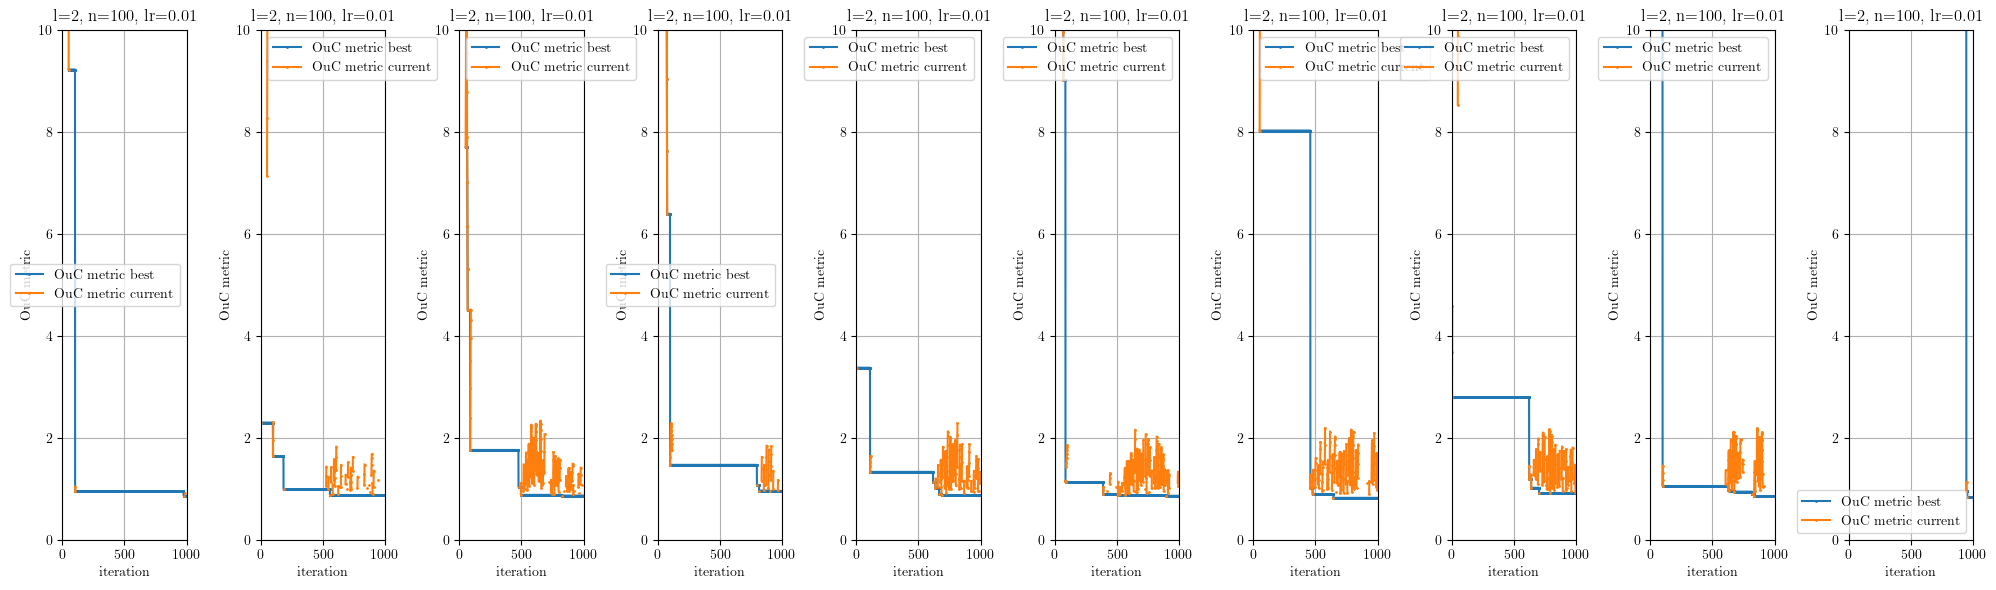

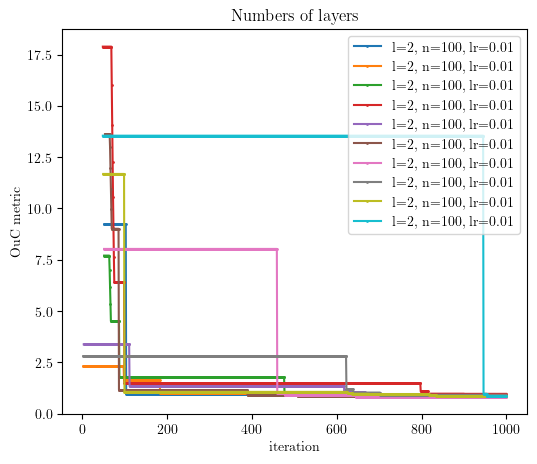

In [31]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 50.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8280054 MSE solution: 0.0004446063068460449 ratio: 0.086 time: 58.17484426498413
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8560397 MSE solution: 0.0009885674794711614 ratio: 0.068 time: 57.08243536949158
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.87086856 MSE solution: 0.0009260468196362924 ratio: 0.169 time: 57.29068851470947
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8515966 MSE solution: 0.0005094719782075673 ratio: 0.11 time: 55.50191330909729
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.83342993 MSE solution: 0.00035804009347139887 ratio: 0.023 time: 52.70680212974548
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8866662 MSE solution: 0.0015384851675005005 ratio: 0.04 time: 58.031707525253296
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.86377 MSE solution: 0.0018966994007471724 ratio: 0.083 time: 59.51092052459717
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8575885 MSE solution: 0.0009565524774512757 ratio: 0.12 time: 59.621394634246826
LAYERS: 

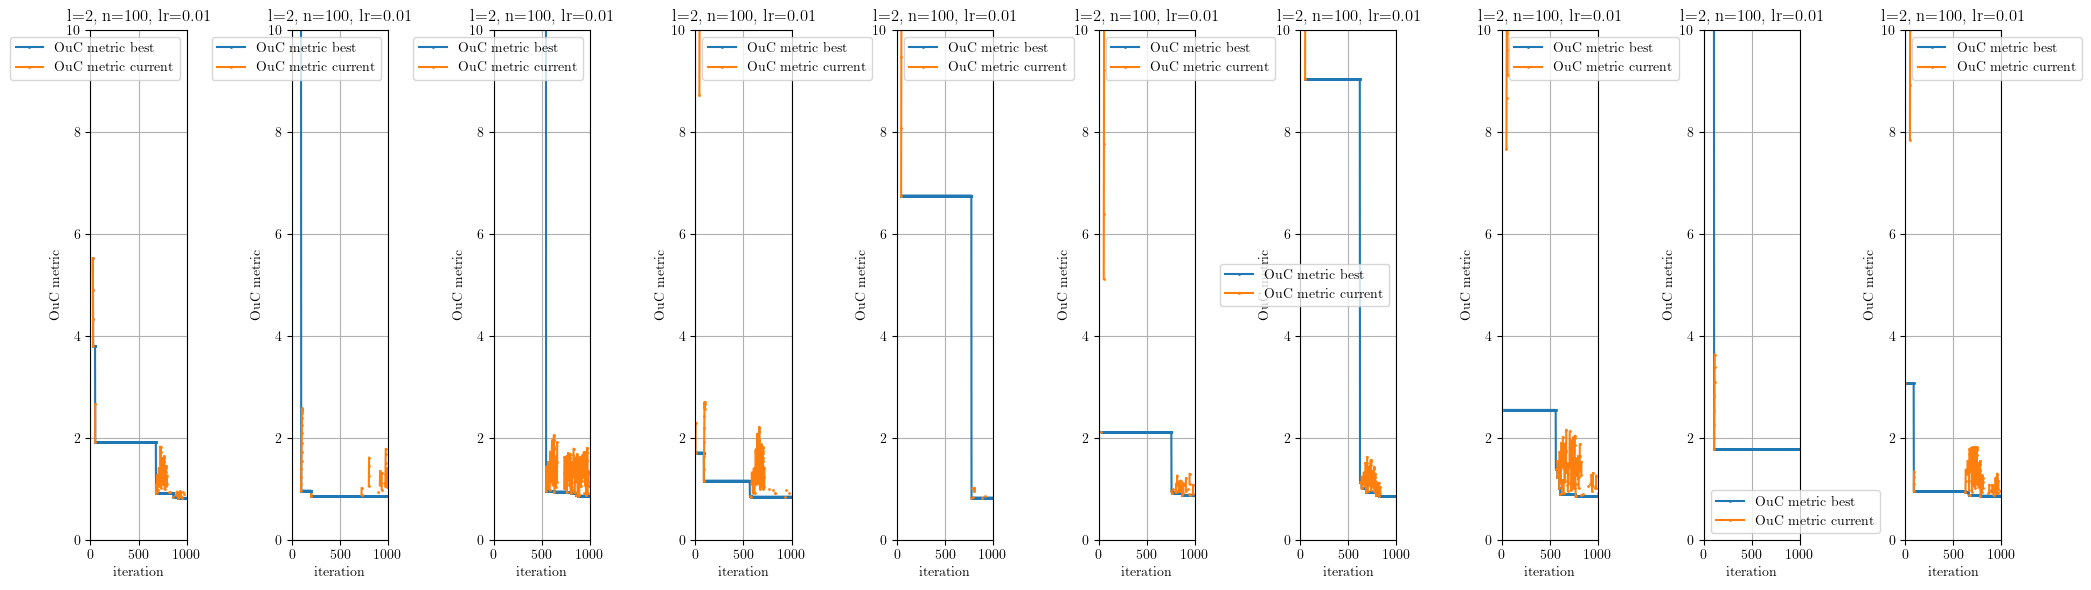

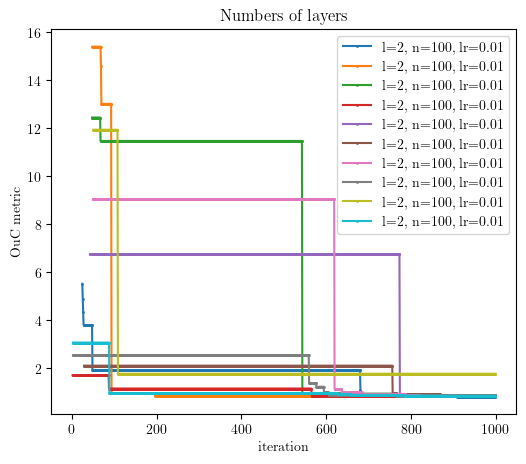

In [32]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 100.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9042147 MSE solution: 0.002920131833478583 ratio: 0.137 time: 48.79036045074463
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.82359535 MSE solution: 0.0003694158551087418 ratio: 0.095 time: 59.35400629043579
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.2002585 MSE solution: 0.37399439264593887 ratio: 0.028 time: 58.06657266616821
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9011753 MSE solution: 0.003991132656503195 ratio: 0.05 time: 58.30874013900757
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9304802 MSE solution: 0.004533122297270715 ratio: 0.102 time: 51.85697293281555
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.81233394 MSE solution: 3.241089511381879e-05 ratio: 0.029 time: 50.60574722290039
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.86278903 MSE solution: 0.0017195310037785945 ratio: 0.127 time: 49.64059567451477
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8419491 MSE solution: 0.0003194326245593971 ratio: 0.066 time: 51.491379737854004
LAYERS: 2 

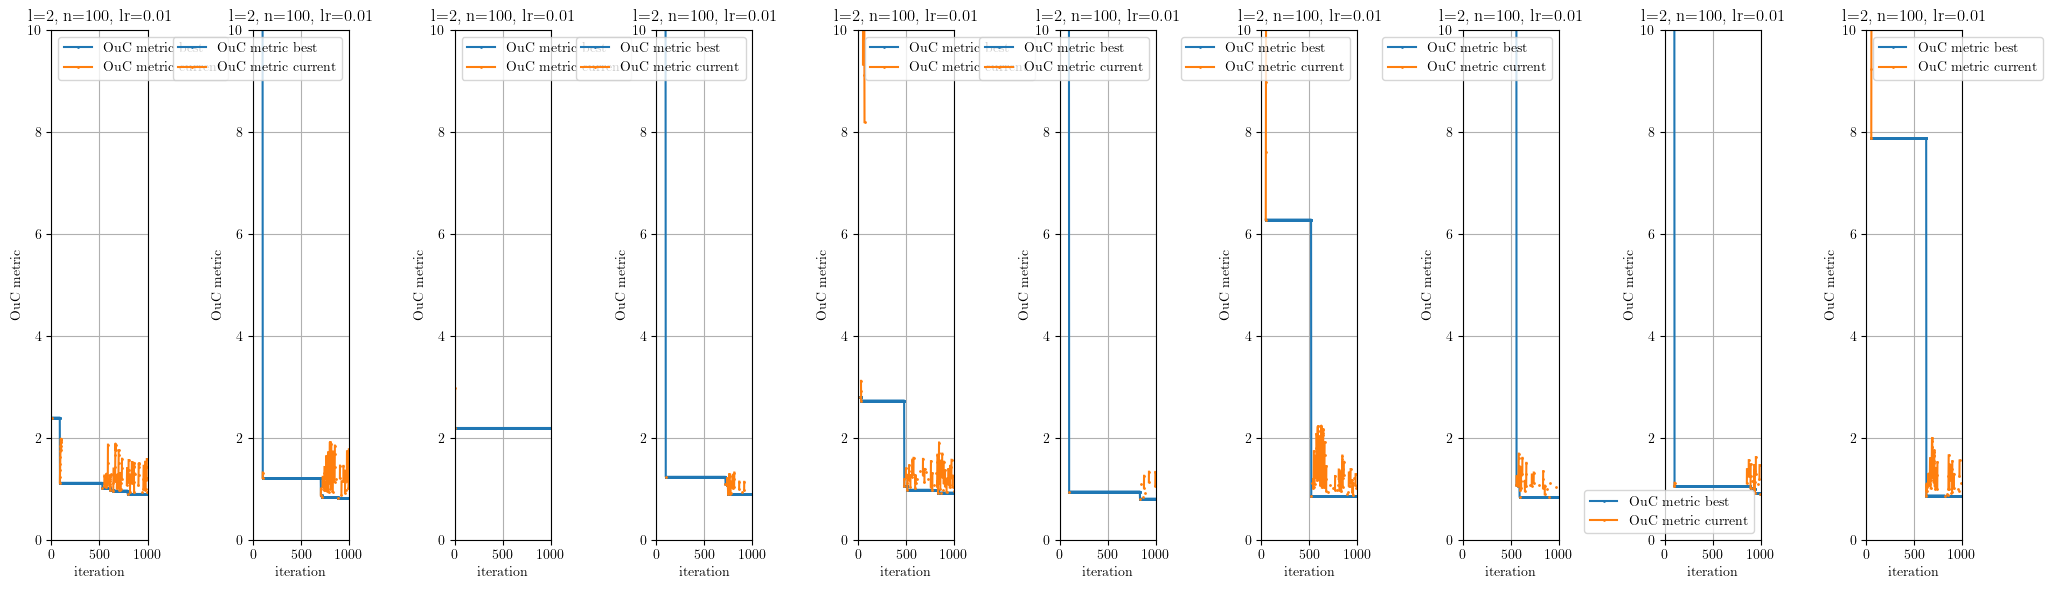

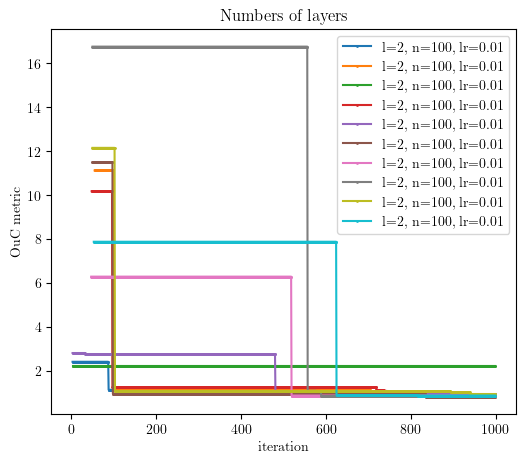

In [33]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 200.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.840977 MSE solution: 0.000450162419124915 ratio: 0.098 time: 50.58444261550903
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8667055 MSE solution: 0.0016389998602051664 ratio: 0.108 time: 50.88884425163269
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8471869 MSE solution: 0.0028621163340024174 ratio: 0.114 time: 49.85089135169983
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8998173 MSE solution: 0.0023563793971659226 ratio: 0.091 time: 54.0781672000885
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8665131 MSE solution: 0.0008091332742922109 ratio: 0.024 time: 55.1540949344635
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8522439 MSE solution: 0.0008144481152051604 ratio: 0.198 time: 51.594350814819336
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8653155 MSE solution: 0.0018395810773891564 ratio: 0.179 time: 51.30232787132263
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8532758 MSE solution: 0.0008057902753217408 ratio: 0.094 time: 50.79741883277893
LAYERS: 2 N

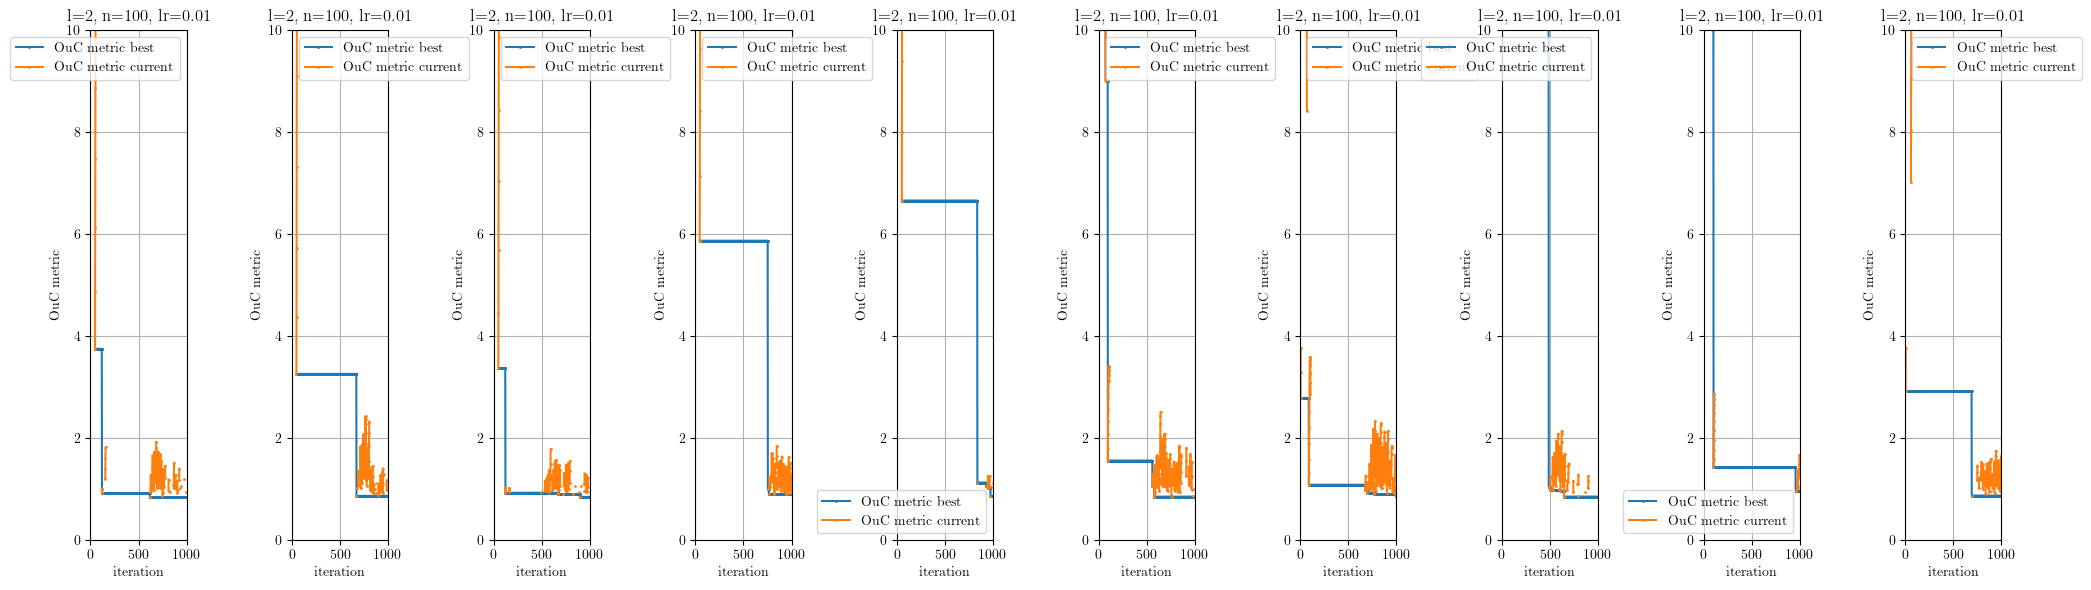

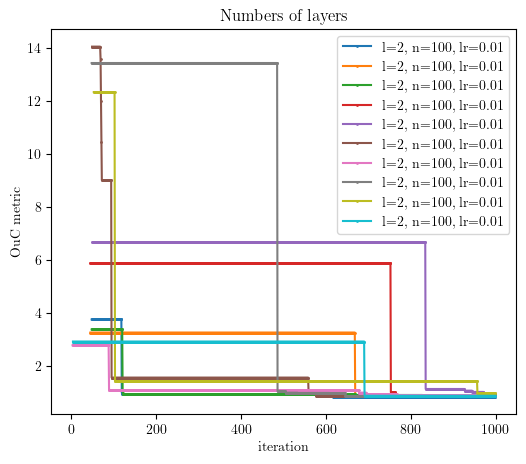

In [34]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 500.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8662212 MSE solution: 0.0009664752653727652 ratio: 0.094 time: 57.43180704116821
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.90576357 MSE solution: 0.004138208089152995 ratio: 0.038 time: 51.77874732017517
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8347331 MSE solution: 0.00025246151855188285 ratio: 0.111 time: 54.356651306152344
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8444152 MSE solution: 0.0004974071253415675 ratio: 0.116 time: 55.93705773353577
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8631074 MSE solution: 0.0010365356489578802 ratio: 0.121 time: 56.90540552139282
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8625984 MSE solution: 0.001749089820649862 ratio: 0.126 time: 50.00271725654602
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8451002 MSE solution: 0.0005781708629950785 ratio: 0.109 time: 51.90915656089783
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8750214 MSE solution: 0.0011880841651650202 ratio: 0.148 time: 51.37727236747742
LAYERS:

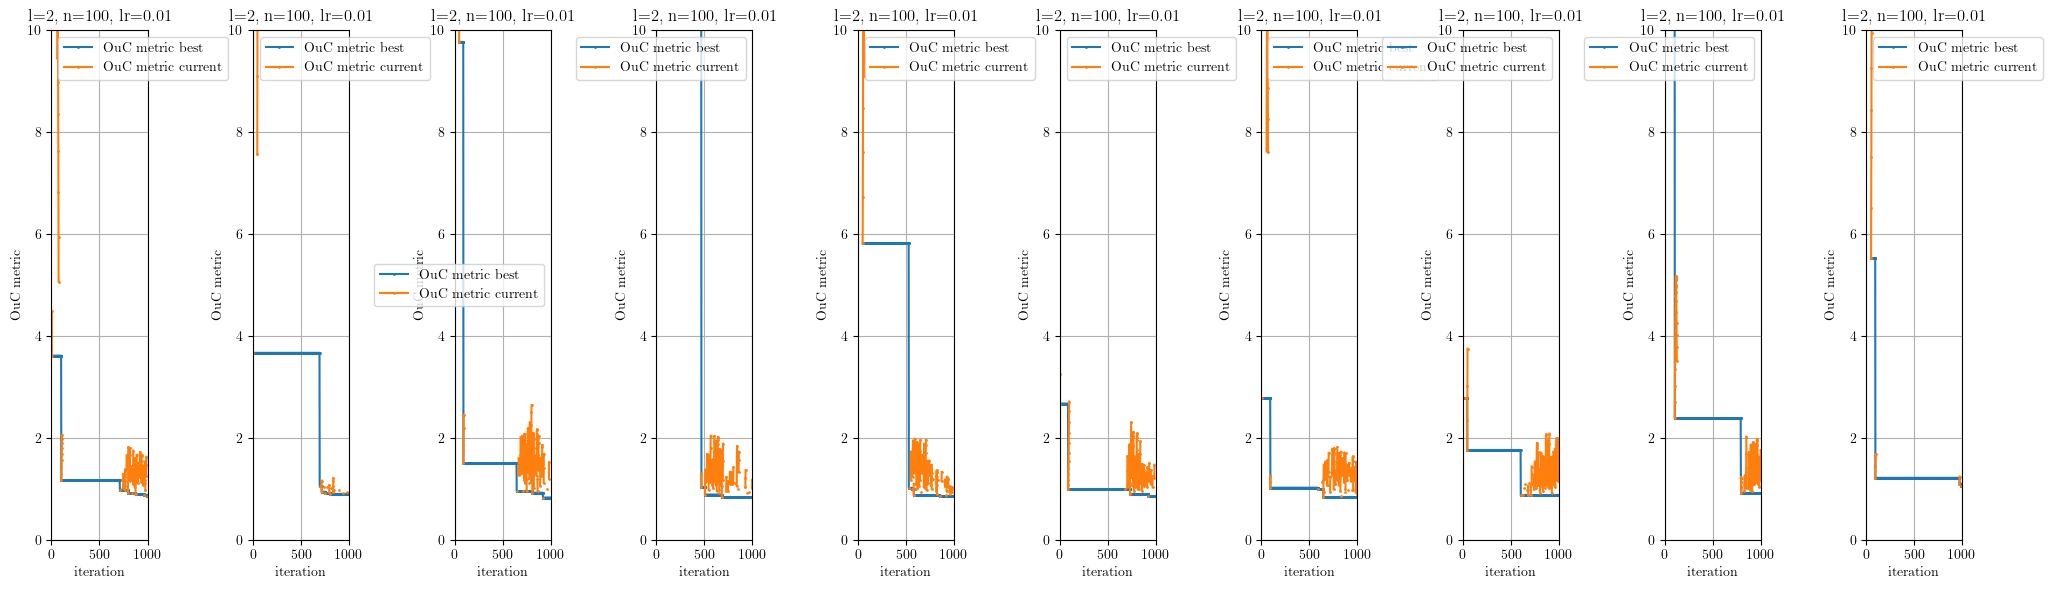

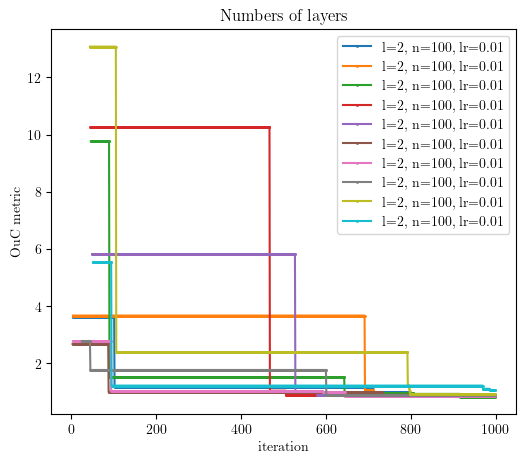

In [35]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 5.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.88698804 MSE solution: 0.0015229319497234572 ratio: 0.143 time: 57.24112629890442
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.83770573 MSE solution: 0.00021516354987076975 ratio: 0.136 time: 59.65621614456177
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.89811426 MSE solution: 0.0033805038984954156 ratio: 0.076 time: 58.81032657623291
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.85524046 MSE solution: 0.0021794398116225166 ratio: 0.061 time: 56.9569628238678
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.86745083 MSE solution: 0.0011428224721335754 ratio: 0.125 time: 58.35277962684631
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.84042937 MSE solution: 0.0005702879691629144 ratio: 0.181 time: 57.379416704177856
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.87948763 MSE solution: 0.0015125206590634697 ratio: 0.09 time: 51.50171661376953
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.863051 MSE solution: 0.0013390601522449775 ratio: 0.122 time: 55.331378698349
LAYE

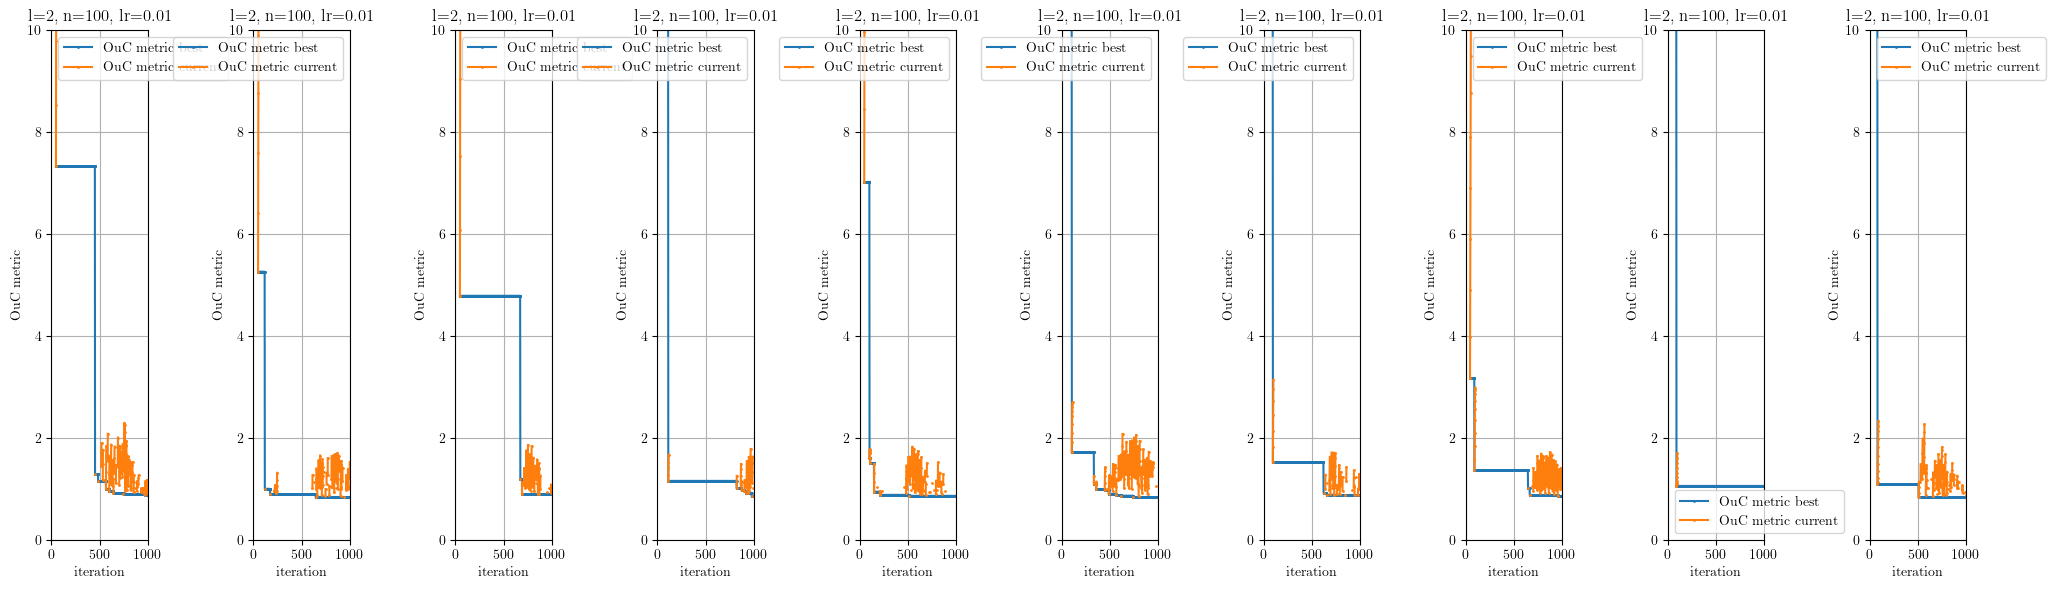

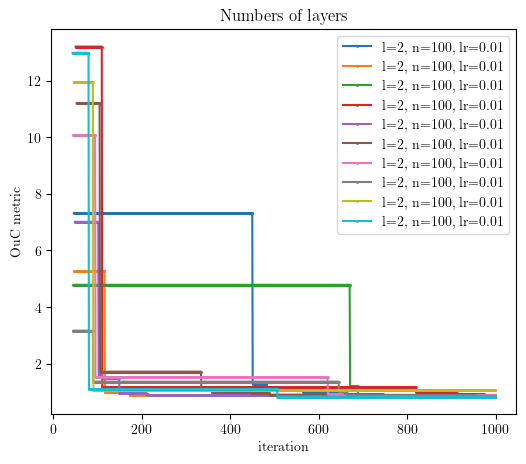

In [36]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 10.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.93079567 MSE solution: 0.0033658814699247734 ratio: 0.132 time: 57.636810302734375
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.83952284 MSE solution: 0.0002712709295988606 ratio: 0.115 time: 58.26259732246399
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.87158656 MSE solution: 0.0012185190112694562 ratio: 0.087 time: 54.89241600036621
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.1143887 MSE solution: 0.026875505030969457 ratio: 0.032 time: 59.369643449783325
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.87530184 MSE solution: 0.0012708548424511651 ratio: 0.153 time: 55.03872466087341
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8543207 MSE solution: 0.0008477939935901323 ratio: 0.142 time: 54.06568431854248
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.84962195 MSE solution: 0.000793991112866414 ratio: 0.084 time: 53.62493896484375
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.88406307 MSE solution: 0.0024333556566364235 ratio: 0.114 time: 55.69737195968628
LA

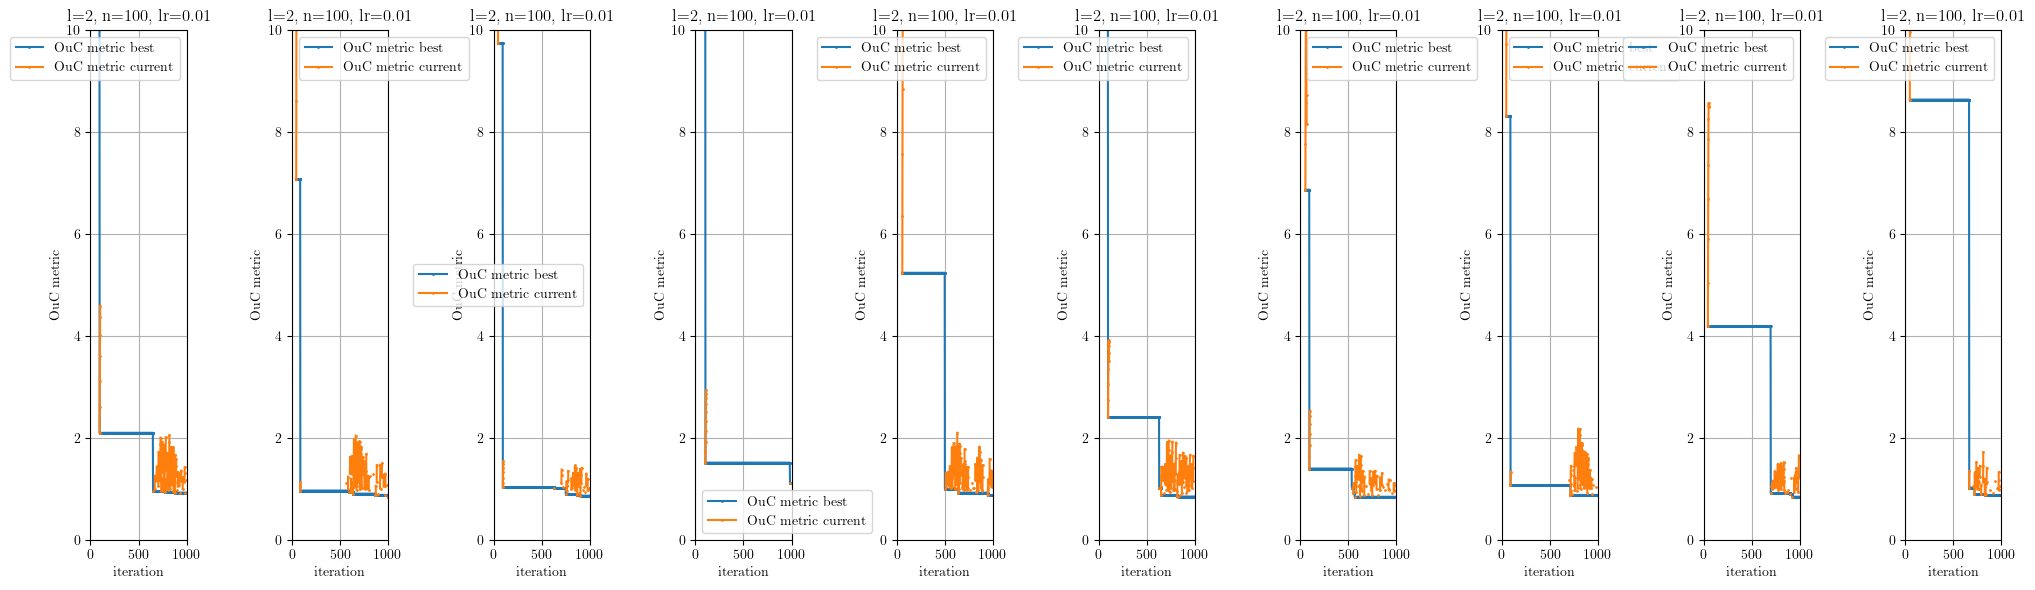

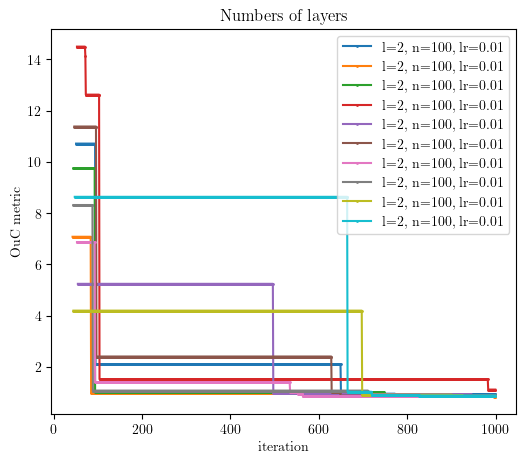

In [37]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 20.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8211049 MSE solution: 0.0005471193190929528 ratio: 0.126 time: 50.847519397735596
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8912313 MSE solution: 0.004222884731871095 ratio: 0.022 time: 59.4339280128479
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.88130534 MSE solution: 0.005401516778039162 ratio: 0.089 time: 57.68042302131653
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.856396 MSE solution: 0.0005686717886782728 ratio: 0.049 time: 59.14491820335388
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.85892016 MSE solution: 0.0006830448537861372 ratio: 0.102 time: 58.789135456085205
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.83042973 MSE solution: 0.00013566909329664094 ratio: 0.184 time: 59.42160105705261
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.84926236 MSE solution: 0.000483299701406895 ratio: 0.101 time: 57.92127275466919
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8784663 MSE solution: 0.0021613029011655744 ratio: 0.091 time: 54.15615129470825
LAYERS

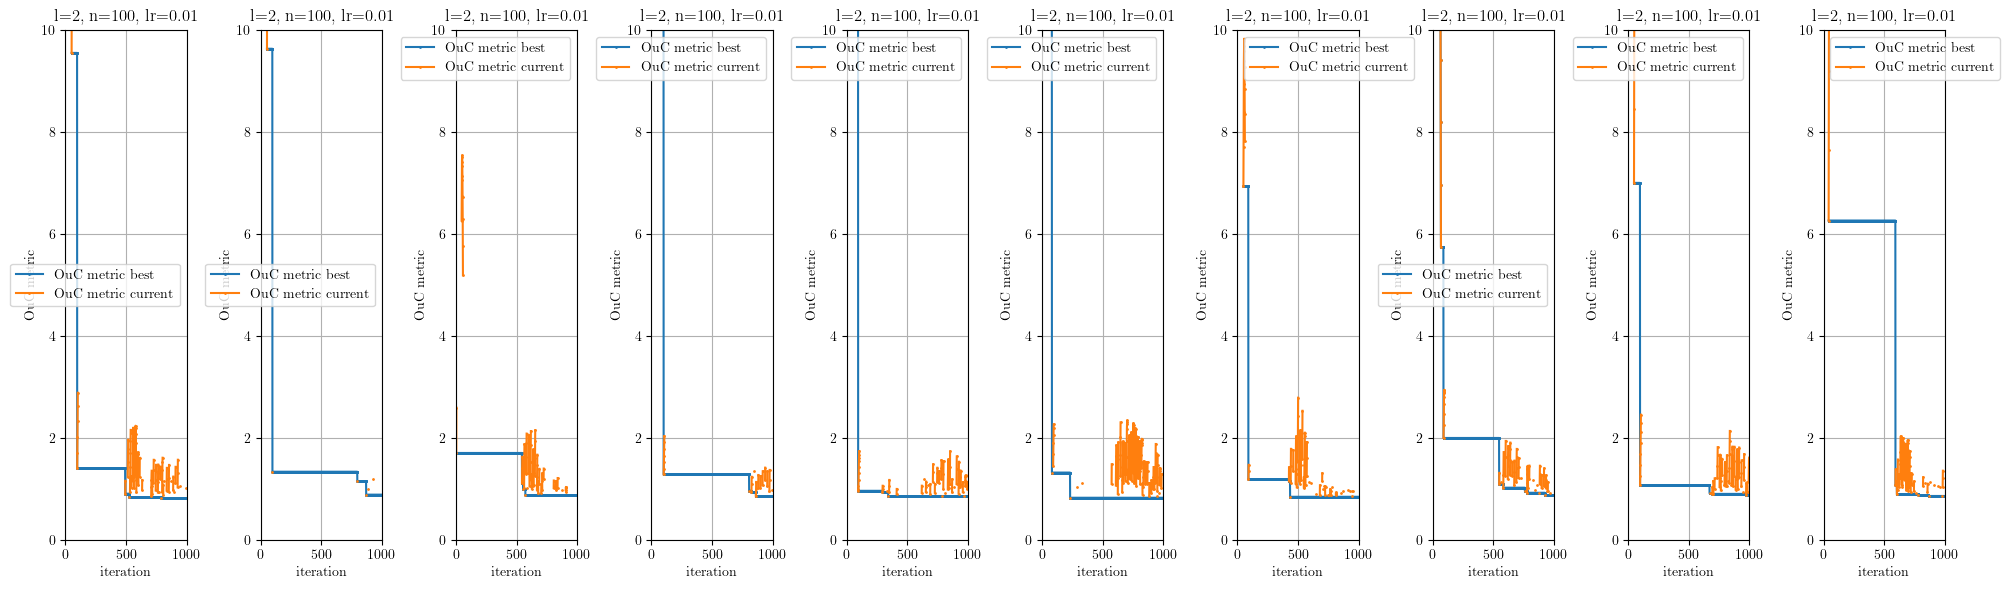

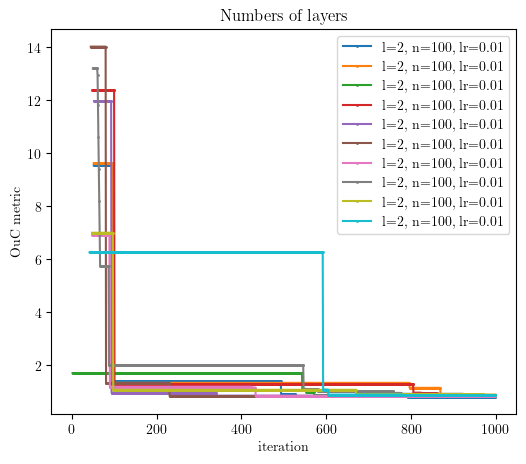

In [38]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 50.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9114692 MSE solution: 0.004805775500742051 ratio: 0.074 time: 53.76976990699768
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8770405 MSE solution: 0.0038696524606979966 ratio: 0.036 time: 60.80096459388733
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.92035085 MSE solution: 0.0033386033741695967 ratio: 0.048 time: 57.58119440078735
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8709485 MSE solution: 0.00392013142817292 ratio: 0.034 time: 50.39421463012695
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.825173 MSE solution: 8.769298141935323e-05 ratio: 0.131 time: 53.17776322364807
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.86789006 MSE solution: 0.000859050917817163 ratio: 0.091 time: 56.64565873146057
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8478619 MSE solution: 0.0007199971923906685 ratio: 0.089 time: 52.91740894317627
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8679177 MSE solution: 0.001231492149929901 ratio: 0.083 time: 58.064656019210815
LAYERS: 2 N

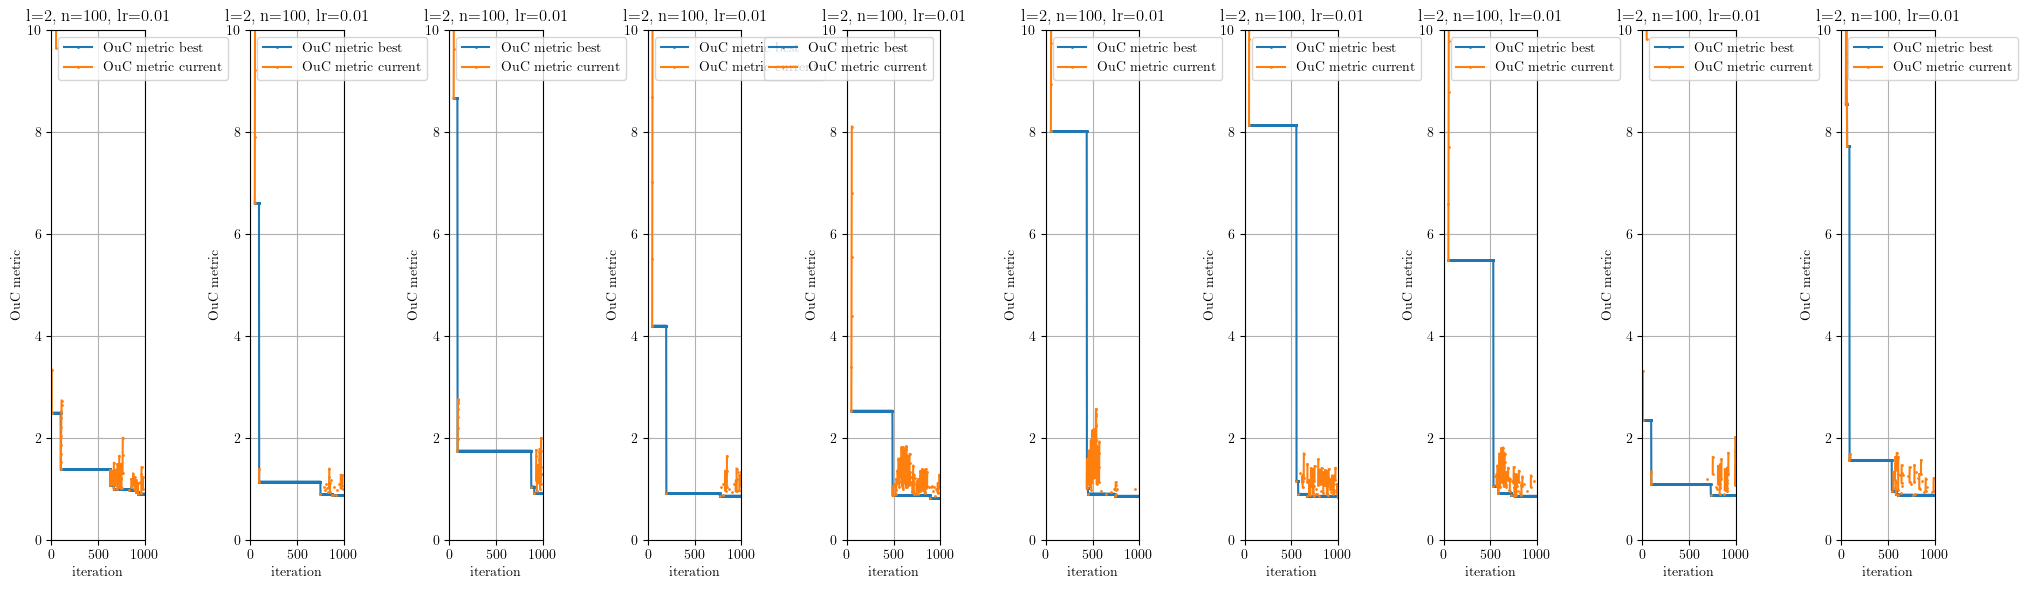

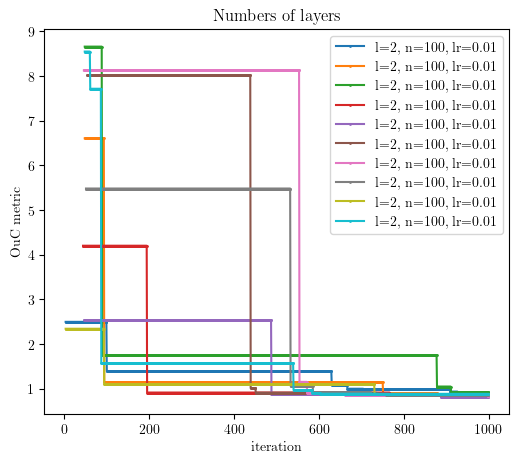

In [39]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 100.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.87269354 MSE solution: 0.0022291152056268665 ratio: 0.121 time: 49.81966018676758
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.887651 MSE solution: 0.0015658039164708909 ratio: 0.135 time: 49.874281883239746
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8559522 MSE solution: 0.0009869571215135565 ratio: 0.027 time: 52.591527223587036
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9179161 MSE solution: 0.006186273872609591 ratio: 0.175 time: 53.193927526474
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.81126577 MSE solution: 1.222836620407623e-05 ratio: 0.124 time: 49.91578245162964
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.82974315 MSE solution: 0.0005645921235318873 ratio: 0.139 time: 49.932114362716675
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8552525 MSE solution: 0.001081857552107342 ratio: 0.109 time: 50.518871545791626
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8875646 MSE solution: 0.005005991223889894 ratio: 0.118 time: 54.00677156448364
LAYERS:

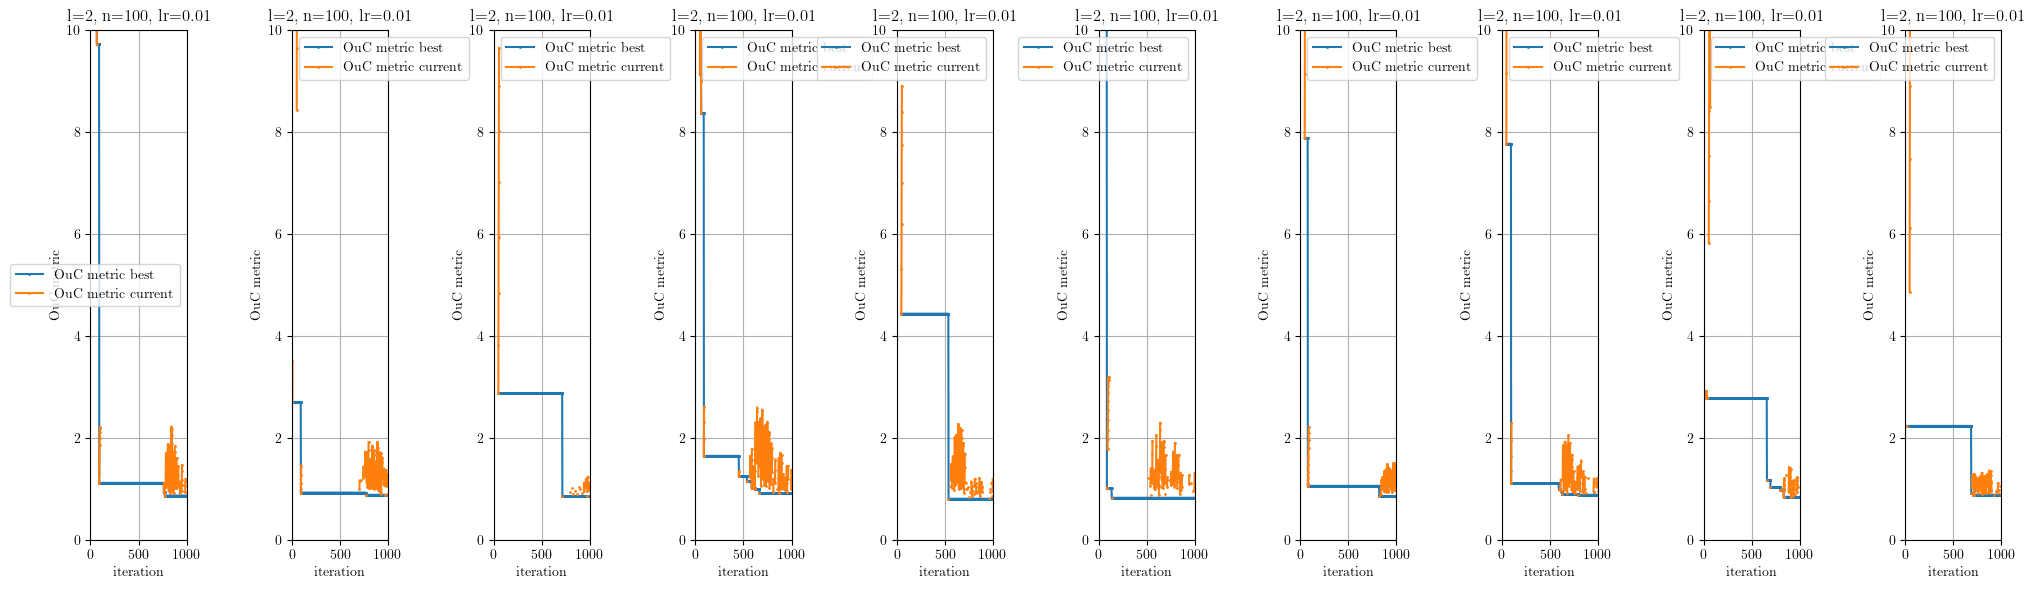

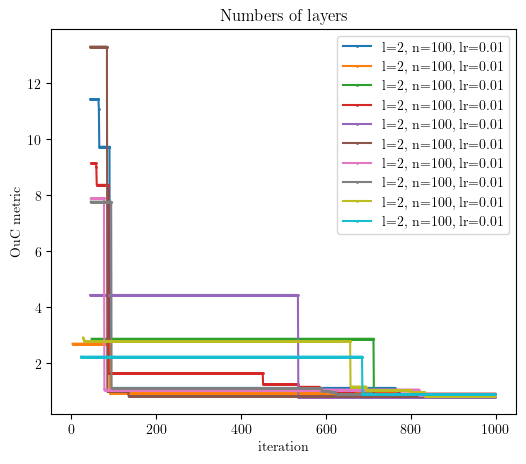

In [40]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 200.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.89774364 MSE solution: 0.002932331693878434 ratio: 0.131 time: 52.12665939331055
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.84894097 MSE solution: 0.00042745517209609517 ratio: 0.082 time: 53.949119329452515
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8775291 MSE solution: 0.0014796584518495847 ratio: 0.101 time: 56.87150168418884
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.85481864 MSE solution: 0.0010790574010474088 ratio: 0.183 time: 49.188748836517334
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.87870157 MSE solution: 0.0018284782390506817 ratio: 0.101 time: 51.13993287086487
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8407083 MSE solution: 0.0013141229969012907 ratio: 0.128 time: 52.32721662521362
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.86635864 MSE solution: 0.003156054292169681 ratio: 0.171 time: 56.290316581726074
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8451783 MSE solution: 0.0009796366627496892 ratio: 0.089 time: 60.09614562988281
L

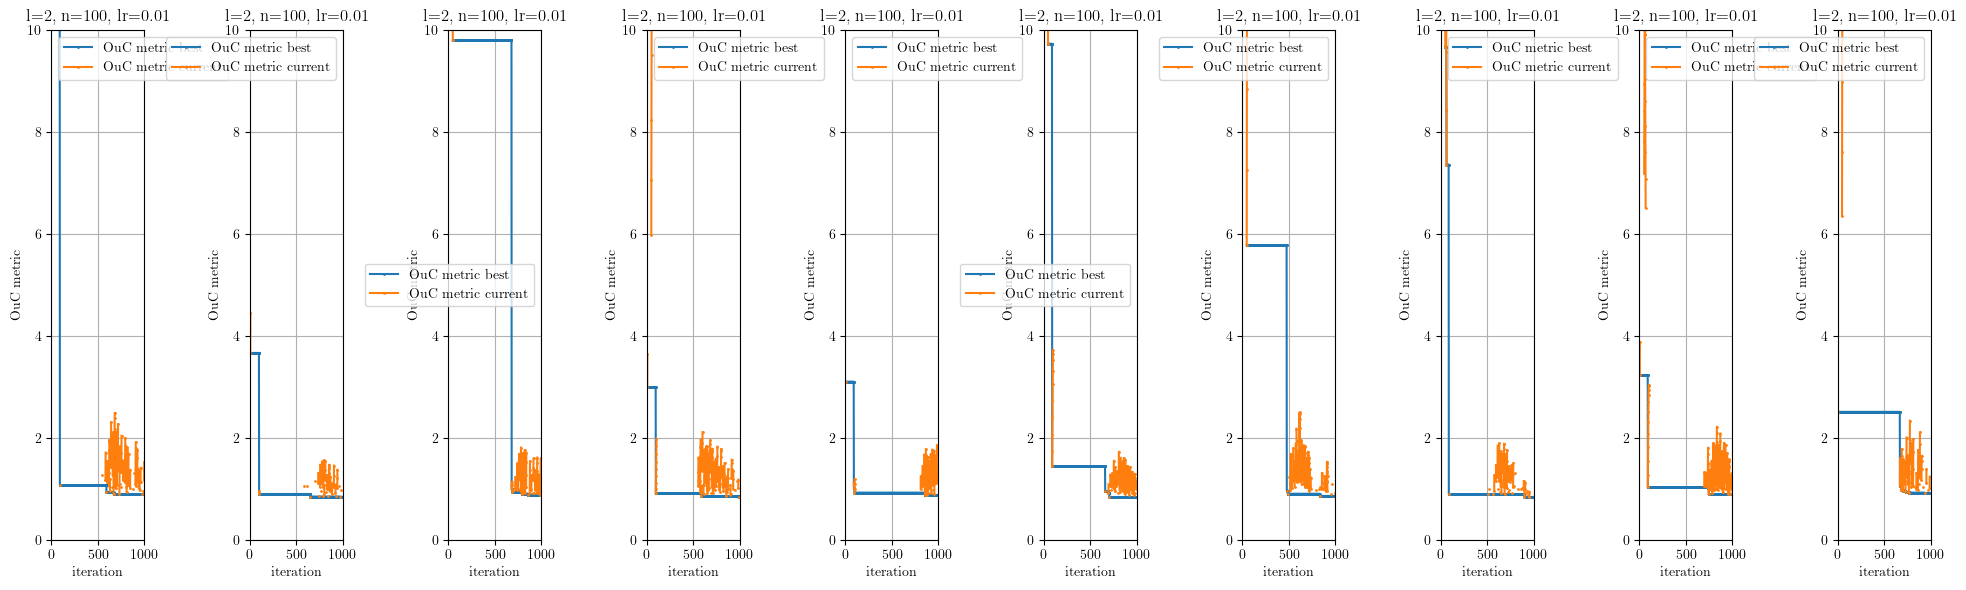

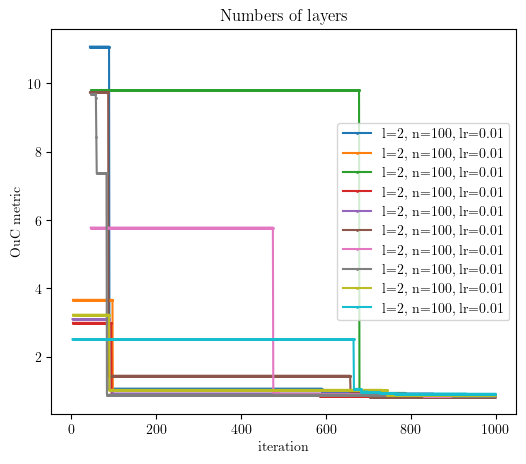

In [41]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 500.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.86633843 MSE solution: 0.0008766836627911596 ratio: 0.138 time: 53.38712286949158
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.86182654 MSE solution: 0.0017963772244586021 ratio: 0.068 time: 57.545791149139404
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.89565474 MSE solution: 0.0019624187578290227 ratio: 0.063 time: 57.61087608337402
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.89680433 MSE solution: 0.0032432605863709674 ratio: 0.17 time: 56.98927712440491
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.87862575 MSE solution: 0.00231318120120552 ratio: 0.043 time: 57.889708280563354
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.0683334 MSE solution: 0.022014698894183397 ratio: 0.015 time: 58.96860647201538
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.85509115 MSE solution: 0.000661128683628919 ratio: 0.145 time: 50.97886419296265
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9649646 MSE solution: 0.014749825949035627 ratio: 0.044 time: 50.46718239784241
LAYERS

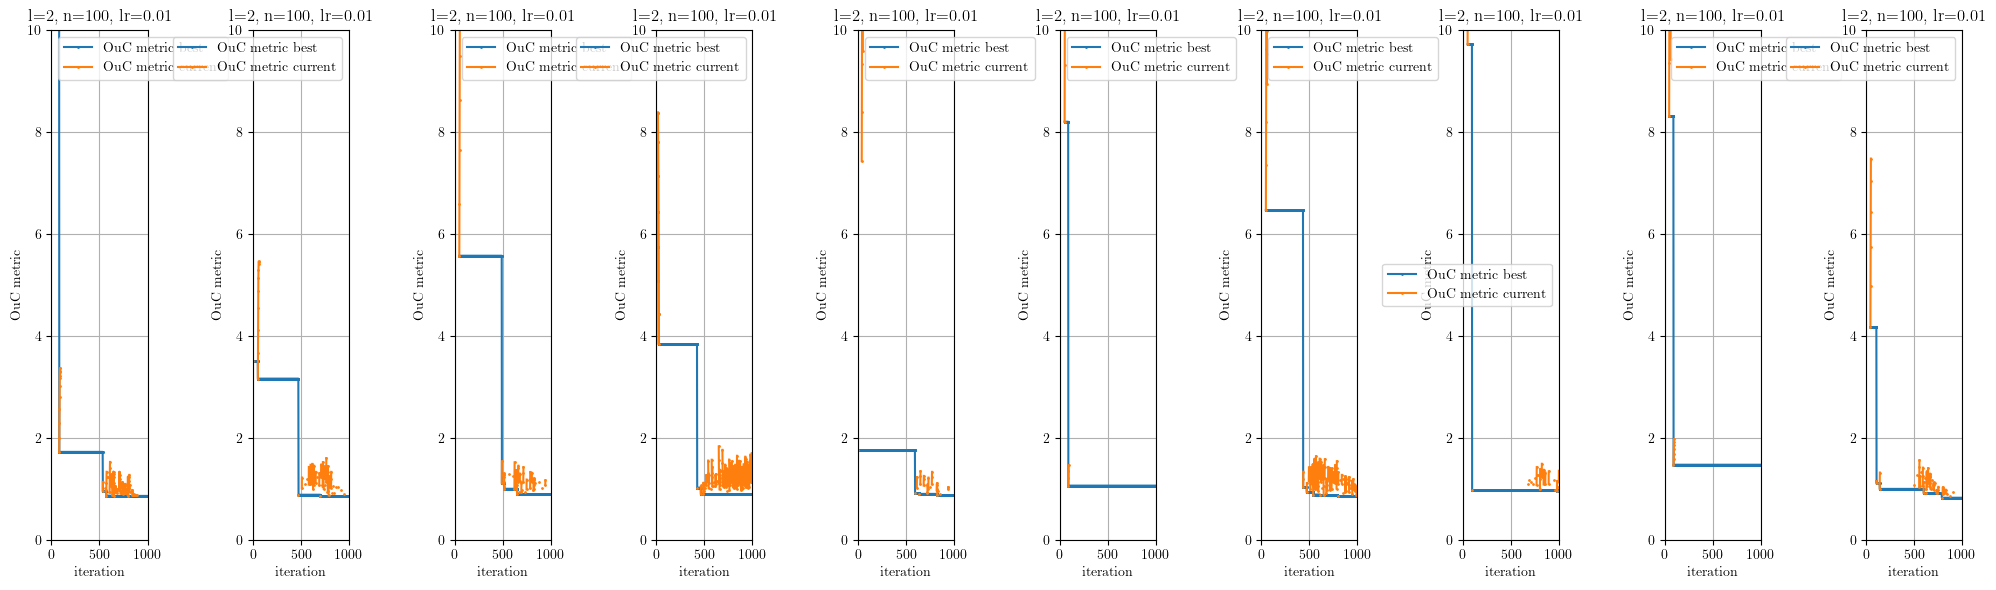

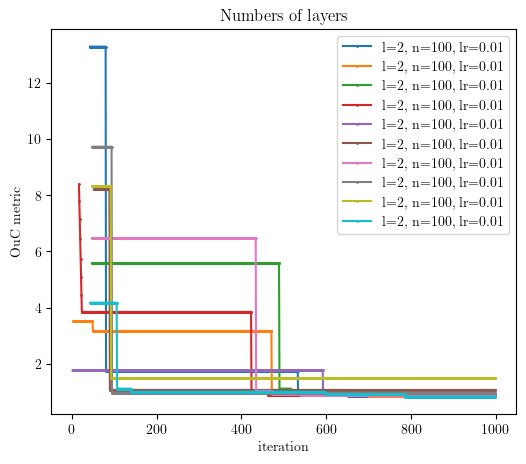

In [42]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 5.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8639471 MSE solution: 0.0031100819567548856 ratio: 0.032 time: 58.28728532791138
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8592583 MSE solution: 0.0010809229318270142 ratio: 0.046 time: 54.50203466415405
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8891016 MSE solution: 0.0018560322867955234 ratio: 0.047 time: 54.136651039123535
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8759052 MSE solution: 0.0014032396179022213 ratio: 0.034 time: 55.38725972175598
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9205149 MSE solution: 0.004926785446266319 ratio: 0.041 time: 52.63350558280945
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.826747 MSE solution: 0.0001667824046292872 ratio: 0.086 time: 55.6846923828125
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8347704 MSE solution: 0.00019288667372780225 ratio: 0.174 time: 56.032254695892334
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8713412 MSE solution: 0.0019071615659743205 ratio: 0.287 time: 56.596186876297
LAYERS: 2 

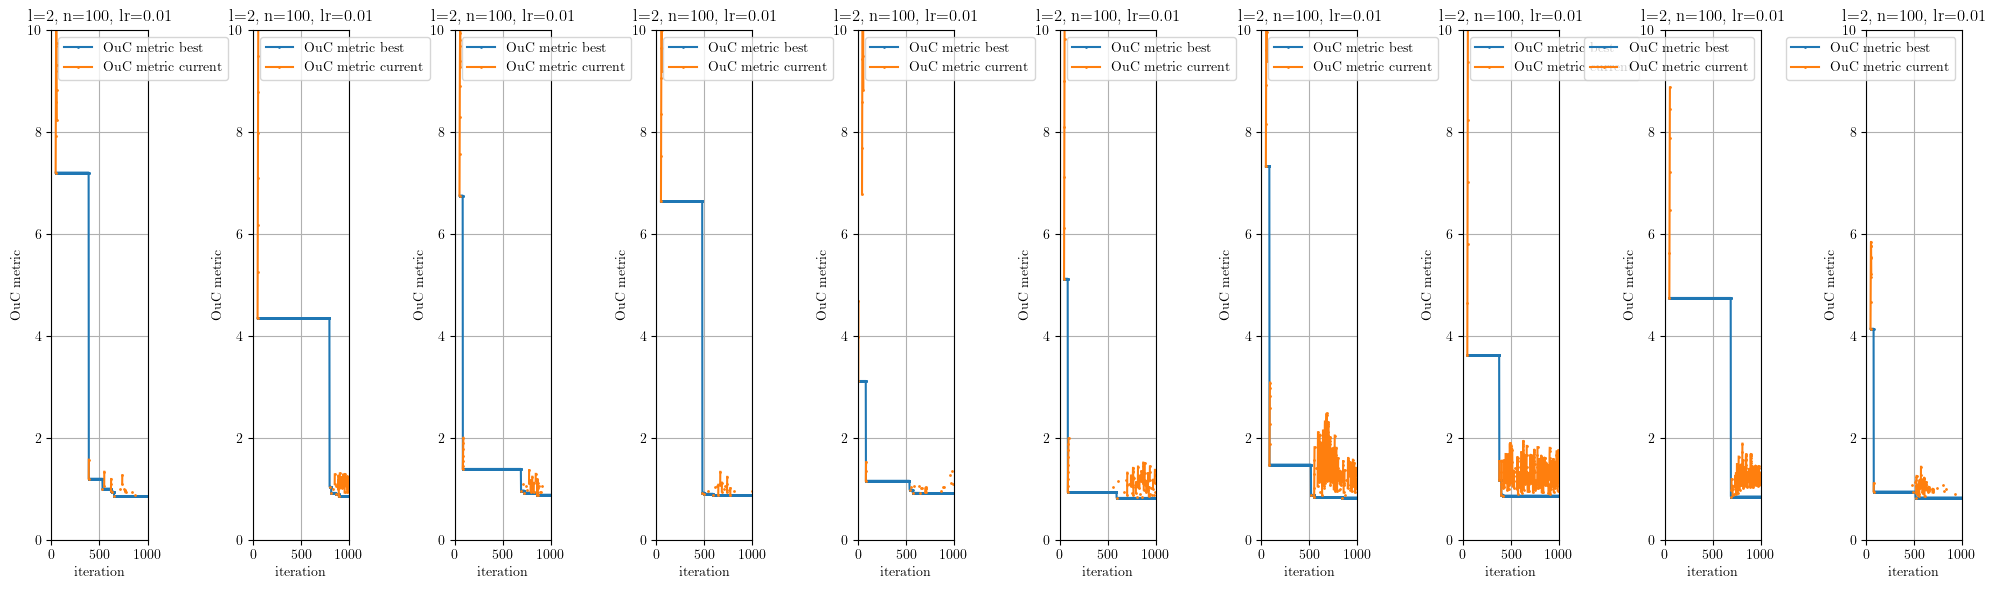

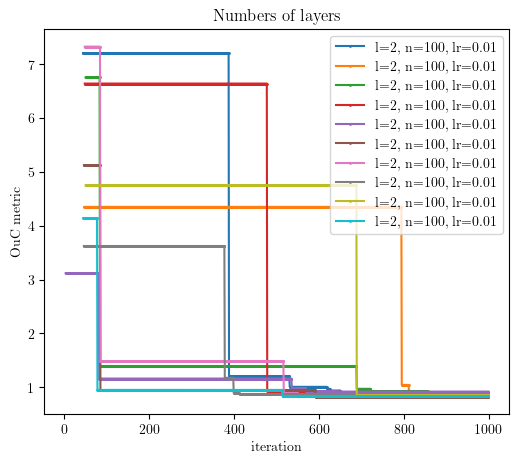

In [43]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 10.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9196389 MSE solution: 0.004624169508178848 ratio: 0.022 time: 54.106452226638794
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8754294 MSE solution: 0.0022931020696652987 ratio: 0.134 time: 55.21077299118042
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.5844593 MSE solution: 0.11452934888249372 ratio: 0.03 time: 54.897000789642334
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9068079 MSE solution: 0.005963947695161754 ratio: 0.032 time: 52.15778636932373
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8266572 MSE solution: 0.00010784300268868276 ratio: 0.075 time: 53.598198652267456
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.82975864 MSE solution: 0.000276661390328045 ratio: 0.032 time: 56.323731422424316
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.89743686 MSE solution: 0.003607239357214575 ratio: 0.086 time: 54.8374810218811
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8298548 MSE solution: 0.00016664102843660098 ratio: 0.162 time: 53.57746148109436
LAYERS: 

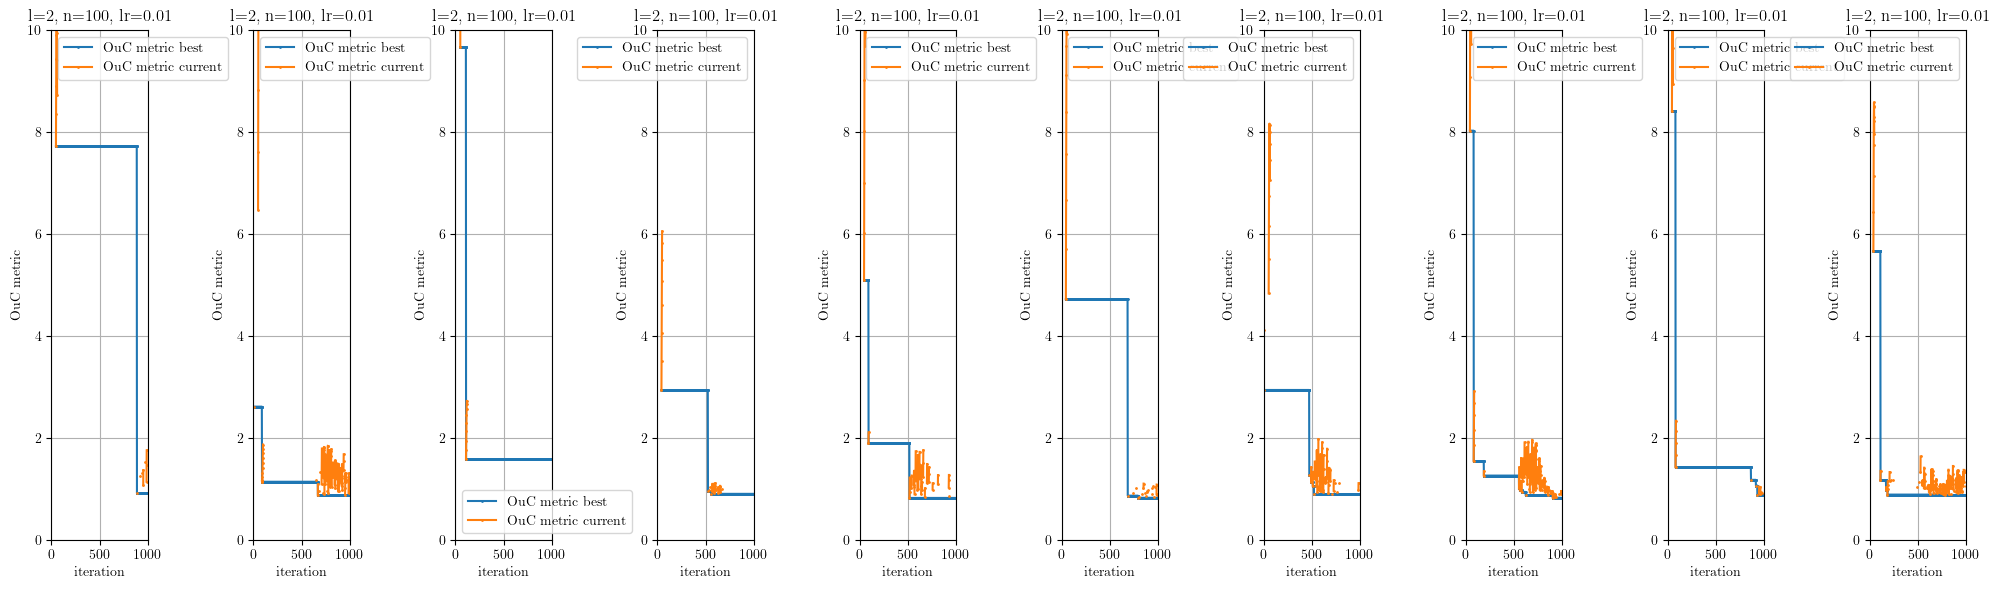

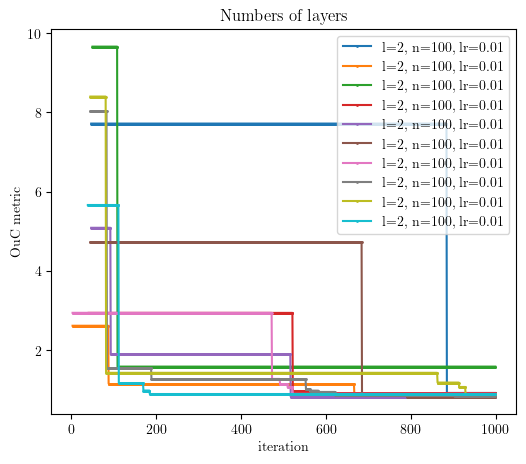

In [44]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 20.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8730916 MSE solution: 0.002133774415107562 ratio: 0.264 time: 54.635876178741455
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.84682184 MSE solution: 0.00045652552467962006 ratio: 0.156 time: 59.1360559463501
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.86444235 MSE solution: 0.0012292562131971342 ratio: 0.042 time: 59.53940010070801
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8463154 MSE solution: 0.0013366350419044132 ratio: 0.064 time: 57.34712028503418
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8447123 MSE solution: 0.0007010937152800035 ratio: 0.125 time: 51.88530731201172
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8524374 MSE solution: 0.00045193226183972264 ratio: 0.187 time: 52.52026987075806
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8436634 MSE solution: 0.0005004534822846583 ratio: 0.058 time: 57.269160985946655
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8577178 MSE solution: 0.0006840301635872458 ratio: 0.228 time: 58.220338106155396
LAY

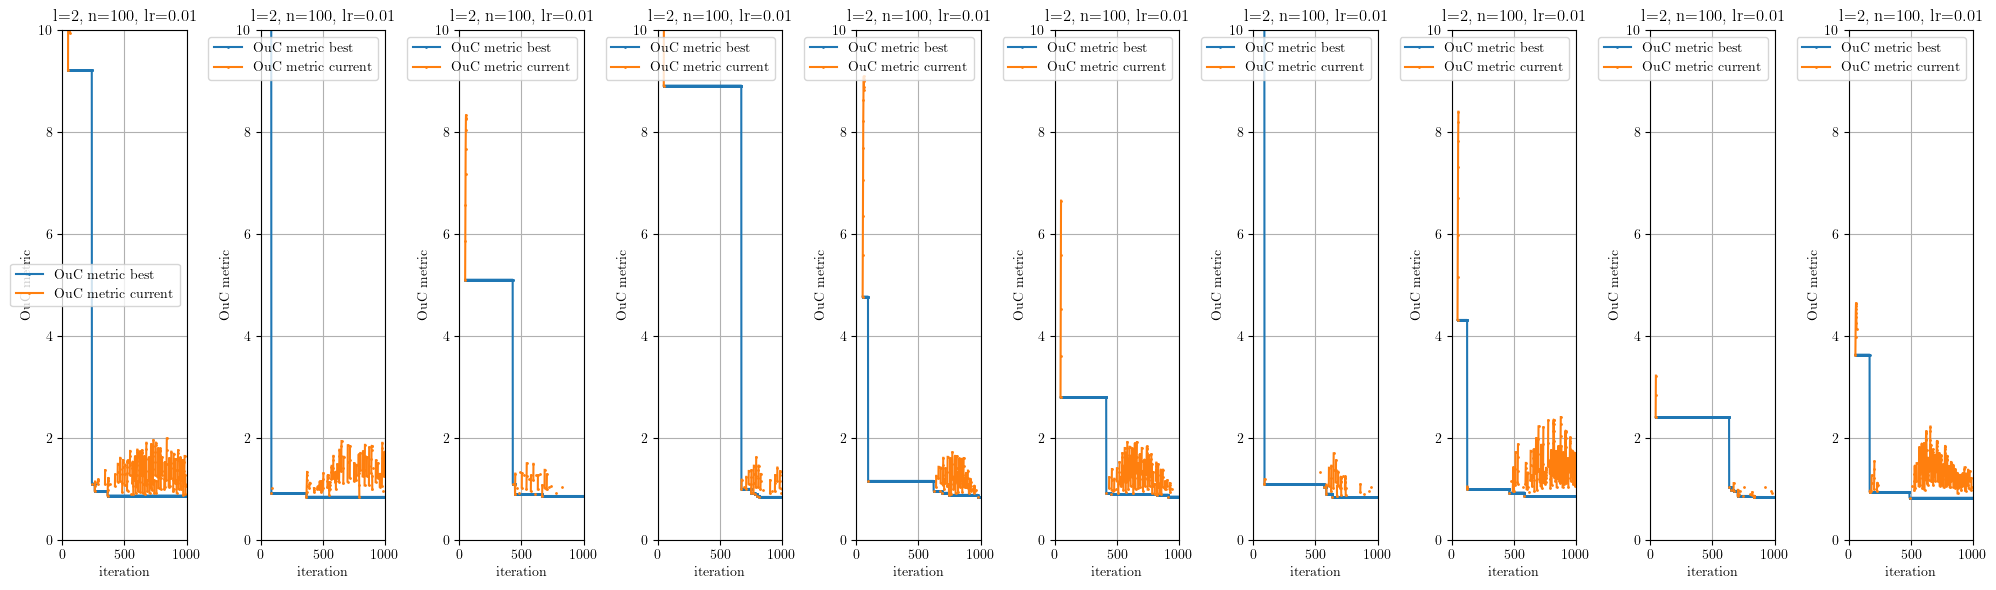

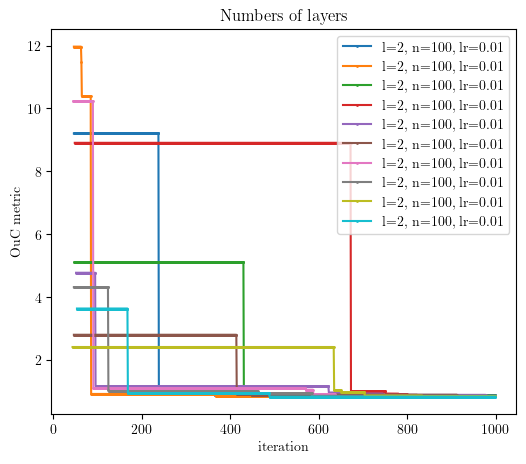

In [45]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 50.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.89071524 MSE solution: 0.001584449110511211 ratio: 0.061 time: 57.29497289657593
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8861269 MSE solution: 0.0037042589474312244 ratio: 0.032 time: 59.754520893096924
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8974413 MSE solution: 0.004825843058938225 ratio: 0.148 time: 57.36737608909607
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8625175 MSE solution: 0.0020370713261721692 ratio: 0.068 time: 58.24546551704407
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.99036103 MSE solution: 0.007546127064449099 ratio: 0.023 time: 57.34459590911865
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.86644197 MSE solution: 0.0016614345781756142 ratio: 0.08 time: 53.09563374519348
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.84749526 MSE solution: 0.0003641671891439512 ratio: 0.184 time: 56.896610498428345
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.84571636 MSE solution: 0.0005321624448572694 ratio: 0.194 time: 57.23025155067444
LAYER

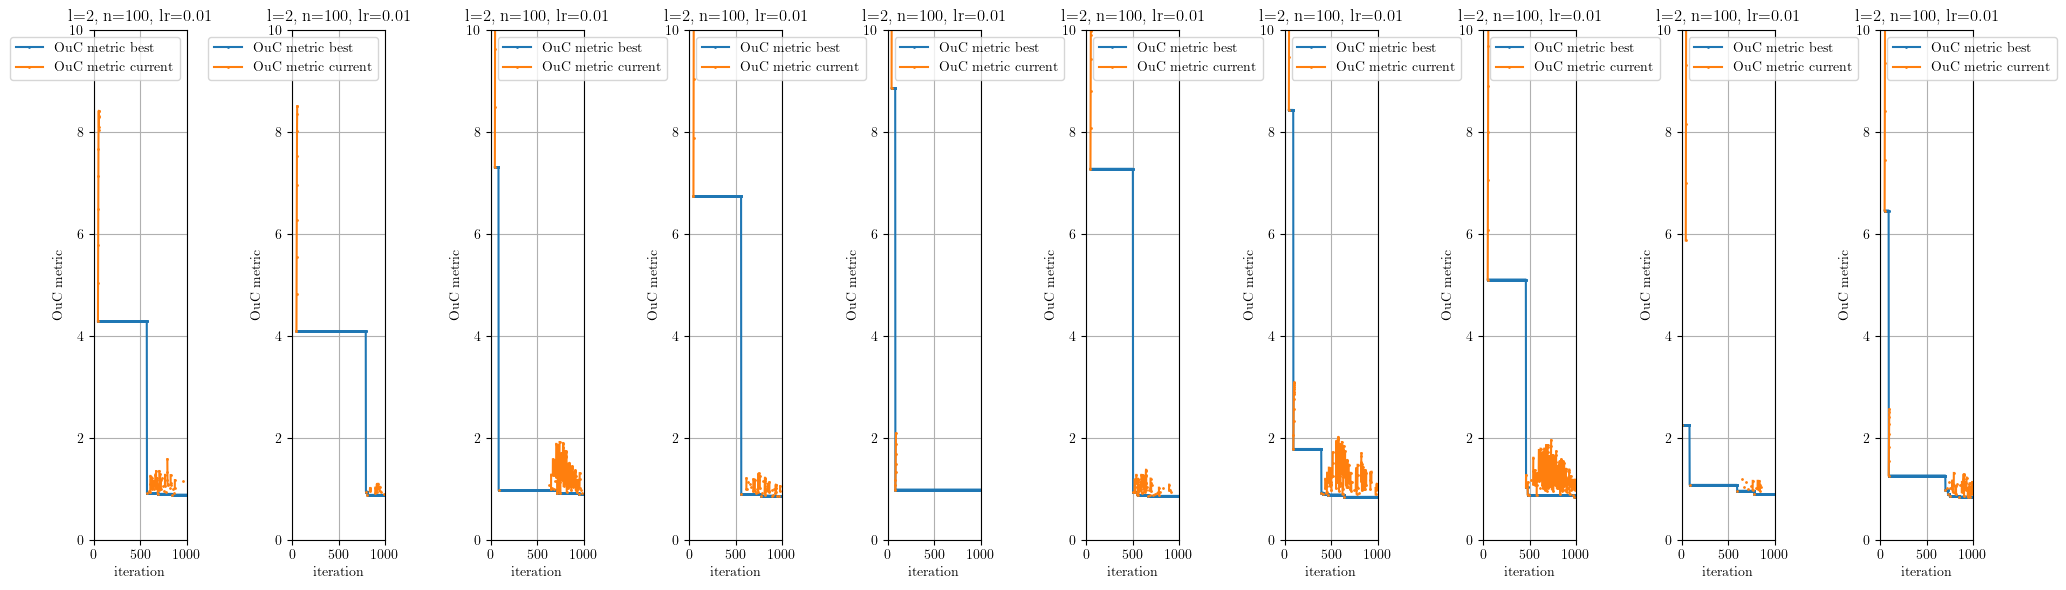

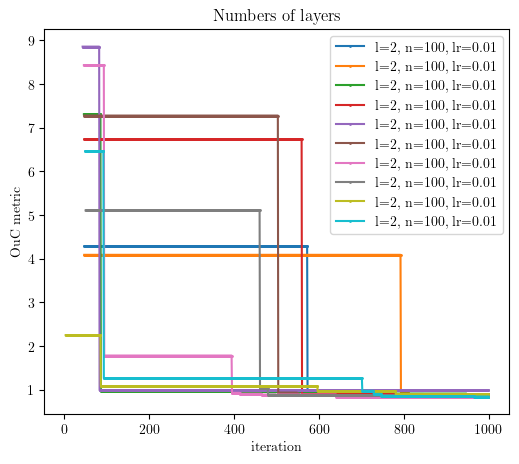

In [46]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 100.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.84115267 MSE solution: 0.0004967621913719059 ratio: 0.071 time: 54.60610008239746
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.88380677 MSE solution: 0.0012901711125462446 ratio: 0.099 time: 55.200098276138306
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8531288 MSE solution: 0.0009173033396113746 ratio: 0.162 time: 57.495463371276855
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.84517366 MSE solution: 0.002060402263674489 ratio: 0.054 time: 56.230029582977295
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8487544 MSE solution: 0.0007904272045963751 ratio: 0.184 time: 58.04865288734436
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9748468 MSE solution: 0.013561715489750483 ratio: 0.021 time: 58.92660307884216
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.89883757 MSE solution: 0.006083222648080326 ratio: 0.029 time: 56.807177782058716
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8351899 MSE solution: 0.00022359713087346457 ratio: 0.036 time: 59.00242066383362
LA

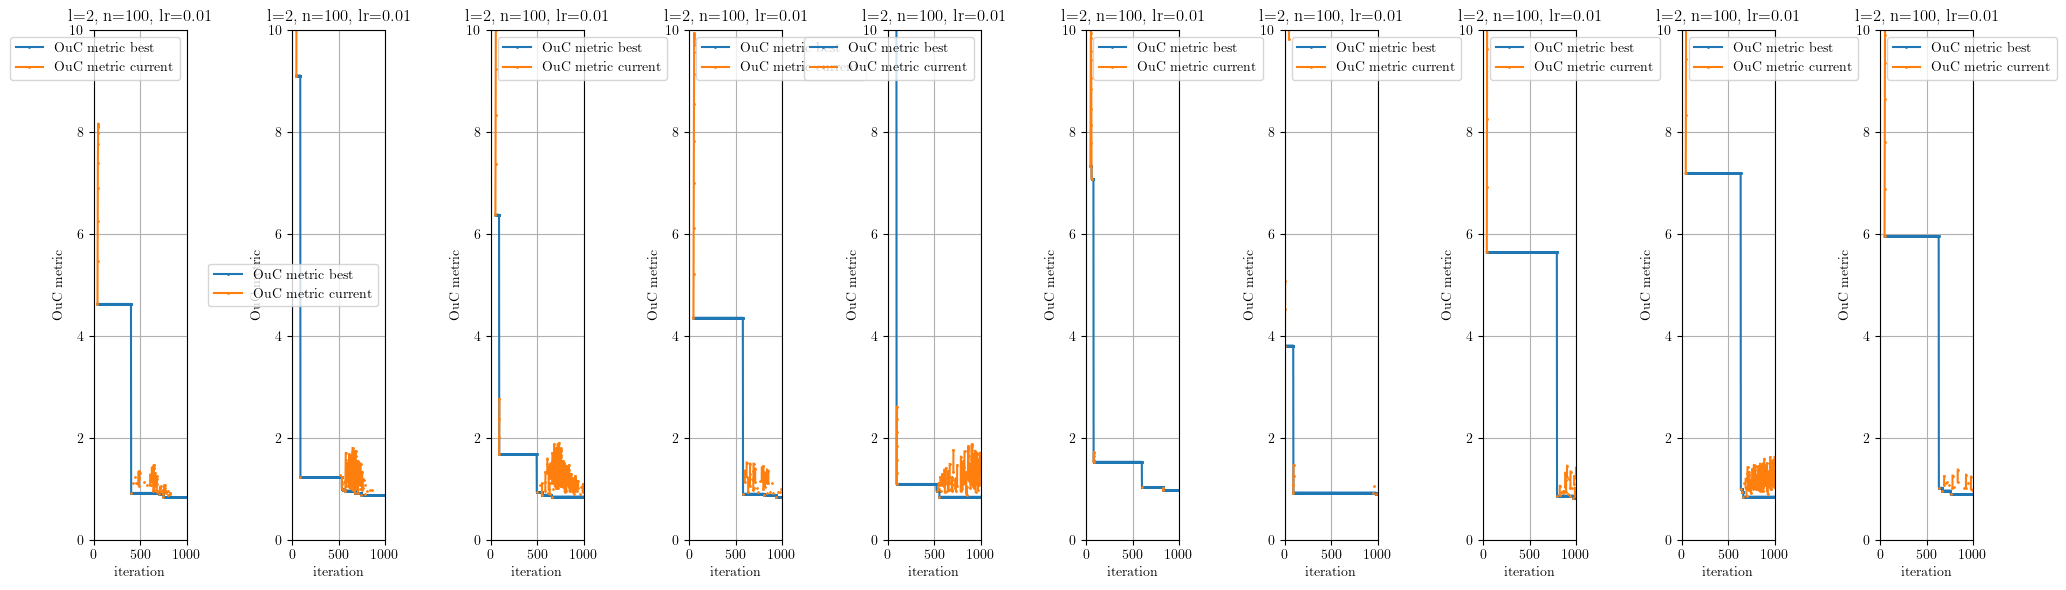

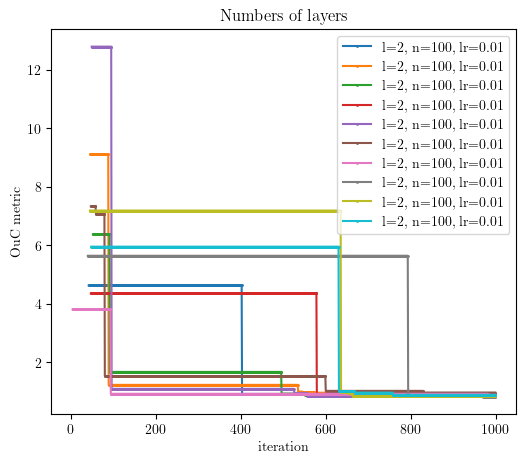

In [47]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 200.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_630424/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_630424/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8699632 MSE solution: 0.0008672023425546124 ratio: 0.096 time: 52.05168700218201
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.83969027 MSE solution: 0.0003808668502647255 ratio: 0.043 time: 51.57693672180176
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.0827655 MSE solution: 0.016068626105157472 ratio: 0.024 time: 51.68673801422119
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8831546 MSE solution: 0.0017171595812482748 ratio: 0.151 time: 54.2900595664978
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.85012376 MSE solution: 0.0011811340213755677 ratio: 0.111 time: 54.72168755531311
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8355449 MSE solution: 0.0005954118913715661 ratio: 0.25 time: 53.643303632736206
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8981552 MSE solution: 0.005459011745193542 ratio: 0.099 time: 54.37185573577881
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.84310013 MSE solution: 0.0004182600629710494 ratio: 0.111 time: 56.4707977771759
LAYERS: 2

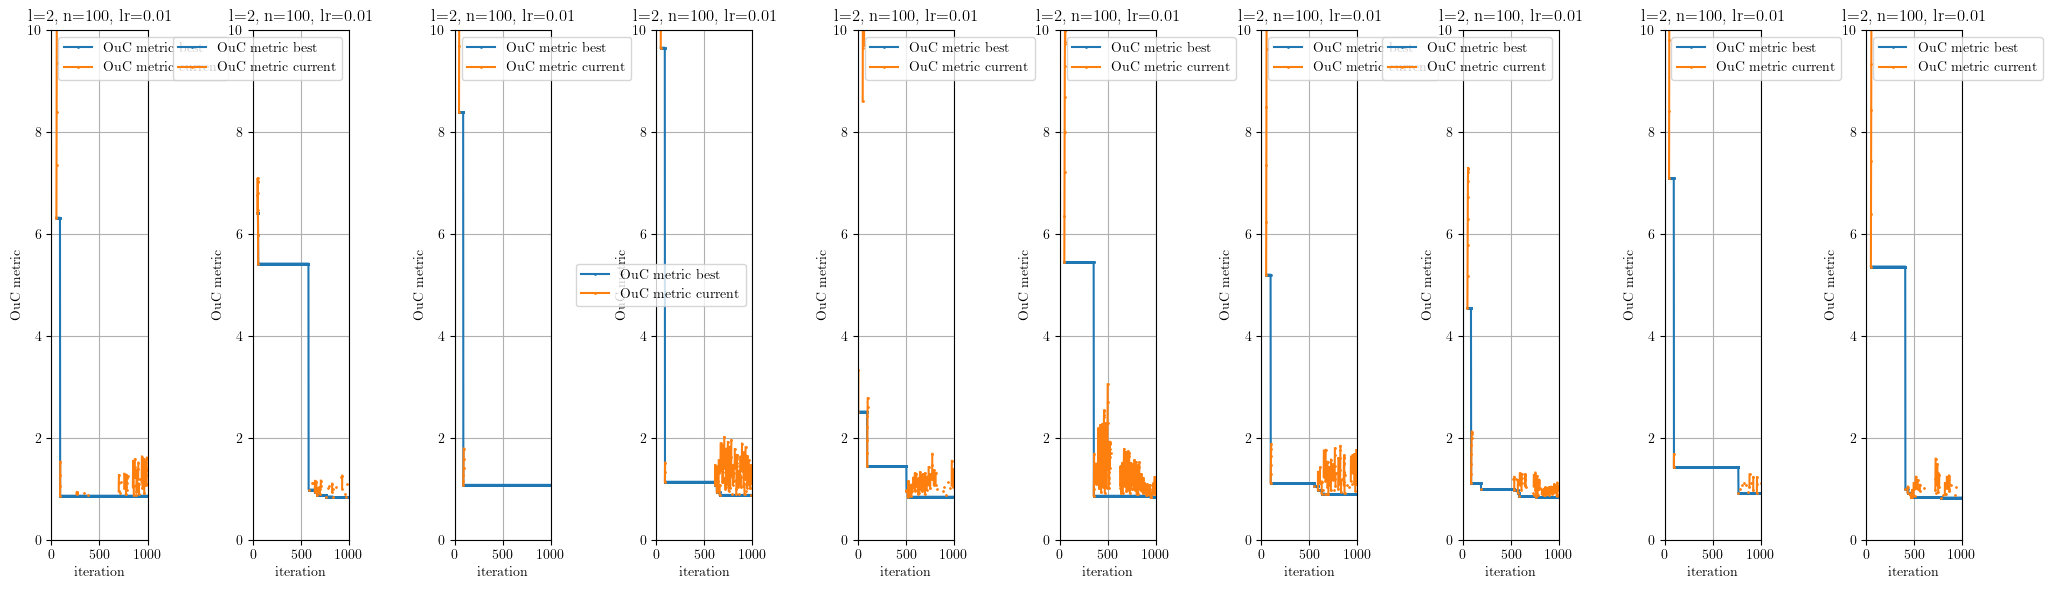

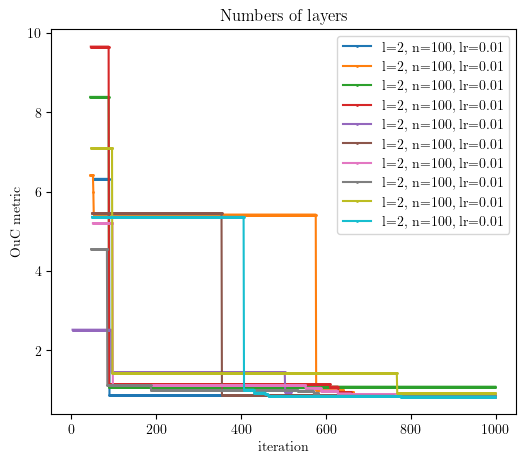

In [48]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 500.0
res_learning_rate = try_lr([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

In [49]:
import plotly.express as px
import pandas as pd

# Convert the list of hyperparameter combinations into a DataFrame
df = pd.DataFrame(hyperparameter_combinations)

# Create an interactive scatter plot with ratio_mean on x-axis and error_mean on y-axis
fig = px.scatter(df, 
                 x='error_mean', 
                 y='ratio_mean', 
                 hover_data=['WEIGHTING', 'CONSTRAINT_WEIGHT'],
                 labels={
                     'ratio_mean': 'Ratio Mean',
                     'error_mean': 'Error Mean'
                 },
                 title='Hyperparameter Tuning: Ratio Mean vs. Error Mean')

# Show the interactive plot
fig.show()

In [50]:
from IPython.display import display
display(df.sort_values('error_mean', ascending=True).style.set_table_attributes('class="table table-hover"'))